<a name="cell-solving"></a>

### 4. [Algorithmic Speed](#cell-sovling-Axb) / [Direct Methods](#cell-sovling-Axb) / [Iterative Methods](#cell-sovling-Axb)  
  0. [Computational Speed](#cell-computational-speed)
    0. [Optimized Operations](#cell-operation-optimization)
    1. [Operation Counting](#cell-operation-counting)
      - [Sequential summation VS the `fan` method](#cell-operation-counting-fan)
    2. ["Big O" Algorithmic Complexity](#cell-sovling-bigO)
        - [[OPTIONAL] $O(n) \text{ and } O(1)$](#cell-sovling-bigO-On-O1)
        - [$O(n^2) \text{ and } O(n^3)$](#cell-sovling-bigO-On2-On3)
          - [[OMITTED] A Counting Example with Convolutions](#cell-FPN-counting)
        - [$O(n\log(n)) \text{ and } O(n^{\log_2 7})$](#cell-sovling-bigO-Onlogn) 
          - [Fast Fourier Transform Preview](#cell-sovling-bigO-Onlogn)

  0. [Direct Methods finding](#cell-sovling-direct-methods) [$X\hat \beta \approx y \text{ by solving } \overset{A\, x}{X^TX \hat \beta} = \overset{b}{X^T y}$](#cell-sovling-direct-methods): Week 4 Programming Assigment Problem 1
    0. [[OPTIONAL] "Big O" Algorithmic Complexity](#cell-sovling-direct-methods-big0)
    1. [[OPTIONAL] Runtimes](#cell-sovling-runtimes)
      - [[OPTIONAL] Comparing  `np.linalg.inv` and `np.linalg.solve`](#cell-sovling-runtimes-inv)
         - [[OPTIONAL] Details on `np.linalg.solve` and `np.linalg.inv`](#cell-sovling-runtimes-solve)
      - [[OPTIONAL] Alternative approaches with `np.linalg.qr`, `np.linalg.cholesky`, and `np.linalg.svd`](#cell-sovling-runtimes-others)
          - [[OPTIONAL] Inversion with `np.linalg.svd`](#cell-sovling-runtimes-svdinv)

    2. [Condition and Numerical Accuracy](#cell-sovling-direct-methods-considerations)

  2. [Iterative Methods](#cell-sovling-iterative)
    0. [Gauss-Seidel](#cell-sovling-gauss-seidel)
        - [[OMITTED] Convergence Properties](#cell-sovling-gauss-seidel-conv) 
        - [[RECOMMENDED] Successive Overrelaxation](#cell-sovling-overrelaxation)
    1. [The quadratic function $\frac{1}{2}x^TAx - x^Tb + c$](#cell-sovling-coordesent-quad)
    2. [Coordinate Descent](#cell-sovling-coordesent)
        - [Nonlinear Gauss-Seidel](#cell-opt-fx-gauss-seidel)
    3. [Line Search](#cell-opt-fx-linesearch)
        - [[OMITTED] Ternary (~~Bi~~Trisection) and Golden Section Search](#cell-opt-fx-golden)
        - [[OMITTED] Goldstein-Armijo Sufficient Decrease, Curvature Conditions](#cell-opt-fx-Goldstein-Armijo)
    4. [Gradient (Steepest Direction) Descent](#cell-sovling-gradients-steepest)        
        0. [Automatic Differentiation](#cell-sovling-gradients-auto): Week 4 Programming Assigment Problem 2
        1. [[RELEVANT] Conjugate Gradient Methods](#cell-sovling-conjugate)
        2. [When is Gradient Descent all that's needed?](#cell-sovling-gdall)

In [2]:
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib

<a name="cell-sovling-Axb"></a>

# 4 $Ax \approx b$ / Algorithmic Speed ([Return to TOC](#cell-solving))

---

There is a often tradeoff between numerical precision and computational efficiency.

> The `fahan` summation method and the recursive formula of the variance calculation from the [Week 2 programming assignment]() were good examples of this.  They both performed extra numerical operations in an attempt to reduce ***roundoff error*** in the sequential operations.

Before looking more closely at the tradeoff between numerical precision and computational efficiency, let's first consider computational efficiency alone.

<a name="cell-computational-speed"></a>

## 4.0 Computational Speed ([Return to TOC](#cell-solving))

---

There are three factors driving the computational speed of any algorithm:

0. How much time does each actual operation in the algorithm take?
1. How many such operations are required to complete the algorithm for a given problem input size?
2. How do required operations scale as the problem size grows?

<a name="cell-operation-optimization"></a>

## 4.1.0 Optimized Operations ([Return to TOC](#cell-solving))

---


Following up on the option [Digital VS Analog Computing]() videos in the [Week 2 Course Notes](), it is exactly the case that computational hardware is built to perform specific operations and is then subsequently optimized for exactly that task. Subsequently, data types and operations on them which directly map onto optimized computational hardware processes can be extremely fast.

This is demonstrated below with the `np.array` data type which can process certain operations up to 100 times faster than a `list` data type.  

In [ ]:
# a "vector" -- mapping directly onto "vectorized" hardware computations
x_np_array = stats.norm().rvs(10000)
# a "linked list" -- which must be traversed sequentially as A->B->C->D->etc.
# and therefore does not simply map right onto a computational hardware operation
n, x_list = len(x_np_array), list(x_np_array)

In [ ]:
%timeit sum(x_list)

In [ ]:
# ultra optimized
%timeit x_np_array.sum()
# ...doesn't do "memory walk" traversing a "linked list" like A->B->C->D->etc.
# ...just gets mapped onto a computational hardware operation which then executes

In [ ]:
# and look how optimized the `x_np_array.sum()` operation is compared to the following
%timeit x_np_array.sum()/n
# summing 10000 is so much faster than dividing by n...

In [ ]:
# Interestingly, x_np_array.sum() is about twice as fast as x_np_array.mean()
%timeit x_np_array.mean()
# Presumably x_np_array.mean() is dividing every number by n before summing them
# which means it requires twice as many computations as x_np_array.sum()
# but this will minimize roundoff overall by accumulating values closer to 0

# This is another good example of the numerical accuracy / computational efficiency tradeoff

In [ ]:
# so instead of x_np_array.sum() the following might be more accuarte
%timeit x_np_array.mean()*n
# but for the example data used here x_np_array.mean()*n == x_np_array.sum()

10.7 µs ± 2.39 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


<a name="cell-operation-counting"></a>

## 4.1.1 Operation Counting ([Return to TOC](#cell-solving))

---

Numeric operations are one basic kind of operations performed in an algorithm. Accessing and placing data in memory is another.

Recall the "two pass" and "single pass" sum of squares algorithms


$$\sum_{i=1}^n(x_i-\bar x)^2 = \underset{\text{first computes } \bar x}{\underbrace{\sum_{i=1}^n x_i^2 - n \bar x^2}_{\text{two pass algorithm}}} = \underset{\text{$\sum_{i=1}^{k-1 \rightarrow k} x_i^2$ and $\sum_{i=1}^{k-1\rightarrow k} x_i$ at step $k$}}{\underbrace{\sum_{i=1}^n x_i^2 - \frac{1}{n} \left(\sum_{i=1}^n x_i\right)^2}_{\text{single pass algorithm increments}}}$$

While the number of arithmetic operations required by each method is the same, the number of memory access operations required by each is different; namely, the two pass algorithm must access the data in memory *twice* as many times as the single pass algorithm. 

> The recursive formulation of the above calcutions does entail additional computations intended to minimize ***roundoff error***, which is more similar to the algorithm employed by `np.var()` function. So the `np.var()` function uses minimal memory access operations, but about twice as many numeric operations as the two "naive" algorithms above.

In [ ]:
def ss_two_pass(x,n):
  sumx2 = x[0]**2
  for i in range(1, n):
    sumx2 = sumx2 + x[i]**2
  sumx = x[0]
  for i in range(1, n):
    sumx = sumx + x[i]
  return sumx2-(sumx**2)/n

def ss_single_pass(x,n):
  sumx = x[0]
  sumx2 = sumx**2
  for i in range(1, n):
    xi = x[i]
    sumx2 = sumx2+xi**2
    sumx = sumx+xi
  return sumx2-(sumx**2)/n

# just numerical operations without accessing memory
def ss_numerical_operations(x,n):
  sumx = x[0]
  sumx2 = sumx**2
  for i in range(1, n):
    sumx2+sumx2**2
    sumx+sumx
  return sumx2-(sumx**2)/n

In [ ]:
%timeit ss_two_pass(x_list,n)

4.64 ms ± 53.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit ss_single_pass(x_list,n)

4.3 ms ± 73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit ss_numerical_operations(x_list,n)

4 ms ± 67.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Indeed, memory access is twice as slow in the two pass versus the one pass algorithms
(4.6-4)/(4.3-4)
# And also notice that the numerical operations themselves (~4 ms)
# are less optimized than the memory access operations (~0.3 ms)

2.0

In [ ]:
# naive two pass algorithm with `x_np_array` like 100x faster than with `x_list`
%timeit (x_np_array**2).sum() - x_np_array.sum()**2/len(x_np_array)

In [ ]:
# single pass `np.var()` "single pass recurrsive" algorithm is twice as slow...
%timeit x_np_array.var(ddof=0)*len(x_np_array)
# because it uses more numerical operations to attempt to reduce roundoff error

<a name="cell-operation-counting-fan"></a>

### The sequential summation versus the `fan` method ([Return to TOC](#cell-solving))

---

The [Week 2 Programming Assignment]() considered a sequential summation algorithm and the alternative `fan` algorithm. Convince yourself that these require the same number of additions. Now, consider the run times below. The difference is not due to a different number of additions since those is the same.  The difference is caused by the the fact that the `fan` requires memory in which to store the new list to pass to the next recursive call of the `fan` function. 

In [ ]:
x = np.linspace(1,2,2**15)

def ss(x):
  x_sum = 0
  for xi in x:
    x_sum += xi

def fan(x):
    '''assumes len(x)=2**p always'''
    if len(x)==1:
        return x
    return fan([x[j*2]+x[j*2+1] for j in range(int(len(x)/2))])    

In [ ]:
%timeit ss(x)

In [ ]:
%timeit fan(x)

<a name="cell-sovling-bigO"></a>

## 4.1.2 "Big O" Algorithmic Complexity ([Return to TOC](#cell-solving))

---

An algorithm requiring $f(n)$ operations to complete a problem with input size $n$ has ***Big $O$*** ***algorithmic complexity*** order $g(n)$, written as 

$$f(n) = O(g(n)) \quad \text{ if } \quad f(n) \leq M g(n) \quad \text{ for all $n>n_0$}$$

for strictly positive $g$ and some constant $M$ that is not a function of $n$.

The "***Big O***" ***algorithmic complexity*** of an algorithm measures the *proportional* computational demands of the algorithm as a function of the input size $n$ of the problem.

> While $f(n) = an^2+bn+c = O(n^2)$, the $O(n^2)$ only characterizes the computational characteristics of an algorithm in the context of very large $n$. 
 Specifying "***Big O***" ***computational complexity*** is pretty simple and generally just requires dropping lower order terms and ignoring proportinality coefficients. The actual runtime of an algorithm for a given input size $n$ depends on $a$ and the lower order terms $bn+c$ but these are not characterized by $O(n^2)$ since as $n$ grows large $an^2+bn+c< Mn^2$ for some large $M$. 
>
> $O(100n) = O(n) < O(n^2)$, but for $n=100$, the actual computational requirements for $f(n)=100n$ and $g(n)=n^2$ would be indistinguishable.  

<a name="cell-sovling-bigO-On-O1"></a>

### [OPTIONAL] $O(n)$ and $O(1)$ ([Return to TOC](#cell-solving))

---

"***Big O***" ***algorithmic complexity*** only characterizes the long term cost of an algorithm as the input $n$ gets larger.  For example, the number of memmory reads for the two pass and single pass sum of squares have the same "***Big O***" ***algorithmic complexity*** 

$$SS_{2pass}^{\#memreads}(n) = 2n = O(n) \quad \text{ and } \quad SS_{1pass}^{\#memreads}(n) = n = O(n)$$

despite the fact that the former requires twice as many actual memory reading computations as the latter. 


The fact that an algorithm has a "***Big O***" ***algorithmic complexity*** $O(n)$ doesn't mean we know the specific computational requirements at a given problem input size $n$; rather, it characterizes that these computational requirements will scale ***linearly*** as a function of $n$.


> As we demonstrated, the memory access costs of the "two pass" algorithm are twice those of the "single pass" algrithm, depite both algorthms having "***Big O***" ***algorithmic complexity*** $O(n)$.
>
> Similarly, the the overall computational requirements of 
> 
> - `ss_two_pass(x,len(x))` and `ss_single_pass(x,len(x))`
>
> are about 100 times that of 
> 
> - `x.var(ddof=0)*len(x)` 
>
> which in turn requires about 2 times that of 
>
> - `lambda x: (x**2).sum() - x.sum()**2/len(x) # x an np.array`
> 
> and yet all of these algorithms have "***Big O***" ***algorithmic complexity*** $O(n)$.

> Another good example that is helpful for understanding the nature of "***Big O***" ***algorithmic complexity*** is the case of $O(1)$, which means that the computational requirements do not change as a function of the size of the input data.
>
> - An example of $O(1)$ is storage requirements **beyond** an input buffer needed to calculate a running mean, sum, or variance from streaming data (since these computations all admit "streaming" one pass calculations).
>    - An algorithm which simply needs to stream through an input buffer,  *even if it does so several times*, is called an ***online*** or **"out of core"** algorithm. This is why the "two pass" sum of squares algorithm was called an ***online*** algorithm.
> - Median calculations do not admit an $O(1)$ storage requirement. The storage requirements of a median calculation are $O(n)$ because to determine which data point is the median the complete data set must be sorted in memory. 
>    - An algorithm with $O(n)$ storage requirements is called a ***batch*** algorithm and requires constant access to the input data.
> - An ***online*** or **"out of core"** algorithm that requires only a *single* pass through an input buffer *and* only has an additional storage requirement of $O(1)$ is called a ***real-time*** algorithm.
>    - Variance calculations using only a single pass of the data are ***real-time*** algorithms; and, covariance matrix calculations also admit ***real-time*** forms; and, linear regression model fitting in fact also has a ***real-time*** form (which doesn't even requires any covariance matrix calculations). 

<a name="cell-sovling-bigO-On2-On3"></a>

### $O(n^2)$ and $O(n^3)$ ([Return to TOC](#cell-solving))

---

Examples of "***Big O***" ***algorithmic complexity*** $O(n^2)$ and $O(n^3)$ are matrix-vector multiplication and matrix-matrix multiplication, respectively. 

- matrix-vector multiplication $A_{n \times n} x_{n \times 1}$ requires $n^2$ multiplications and $n(n − 1)$ additions: $n^2 + n(n − 1) = O(n^2)$

  > $10,000^2 = 100,000,000$ might be computationally tractable; but, $n^2$ for larger $n$ quickly starts to look computationally unappealing...

- matrix-matrix multiplication $A_{n \times n} B_{n \times n}$ requires $n$ matrix-vector multiplication: $n\times(n^2 + n(n − 1)) = O(n^3)$

  > $1000^3 = 1,000,000,000$ *might* be computationally tractable; but, $n^3$ for larger $n$ immediately looks like a computational death trap...

In terms of the problem input size $n$, it becomes quickly apparent that the computational requirements of "***Big O***" ***algorithmic complexity*** $O(n^2)$ and $O(n^3)$ algorithms scale tremendously differently as $n$ increases, and that neither is particularly attractive as a function of $n$ relative to "***Big O***" ***algorithmic complexity*** $O(n)$.

<a name="cell-FPN-counting"></a>

#### [OMITTED] A Counting Example with Convolutions ([Return to TOC](#cell-solving))

---

Determining $O(f(n))$ is simply a matter of defining what's being counted, and then carefully counting it. 

> Consider the following (***convolution***) algorithm $f(n)$ computing the distribution of $p(X_1+\cdots+X_n)$ for discrete $X_i \overset{i.i.d.}{\sim} p(X_i=x)$ with $x \in \{0, \cdots, K\}$:
>
> $$\begin{align*}
p(X_1+X_2 = s) = & {} \sum_{x=0}^{\min(s,K)} p(X_1=s-x) p(X_2=x)\\
p(X_1+X_2+X_3 = s) = & {} \sum_{x=0}^{\min(s,K)} p(X_1+X_2 = s-x) p(X_3=x)  \\
p(X_1+X_2+X_3+X_4 = s) = & {} \sum_{x=0}^{\min(s,K)} p(X_1+X_2+X_3 = s-x) p(X_4=x)  \\
\vdots  & {}
\end{align*}$$

For this example some possible counting targets might be 
- How many multiplications are required to define $p(X_1+\cdots+X_n)$?
- How many additional additions are required to define $p(X_1+\cdots+X_n)$?
- How much storage is required to compute $p(X_1+\cdots+X_n)$?

> To answer the first counting question about multiplication, note that at each stage 
>  1. $\quad p(X_1+X_2)$
>  2. $\quad p(X_1+X_2+X_3)$
>
>    $\quad\quad\quad\quad\vdots$
> 
> $\quad$k. $\quad p(X_1+\cdots+X_k = s)$ must be calculated for $s \in \{0, \cdots, kK\}$
> 
> and each 
> - $p(X_1+\cdots+X_k = s)$ calculation requires the sum of $\min(s,K)+1$ multiplications of $p(X_k)$ with the previous $p(X_1+\cdots+X_{k-1})$, i.e.,
>
>   $$\sum_{x=0}^{\min(s,K)} \underbrace{p(X_1+\cdots+X_{k-1} = s-x)}_{\text{can be cached as a time-space tradeoff}} p(X_k=x)$$
>
>   which can be cached (as a ***time-space tradeoff***) if the algorithm is approached in the natural sequential manner.
>
> Thus, the total number of multiplications required is 
>
> $$\begin{align*}
\overset{\text{stage}}{\sum_{k=2}^n} \overbrace{\sum_{s=0}^{kK} \big(\min(s,K)+1\big)}^{\text{stage $k$ multiplications}} & \leq {} \sum_{k=1}^n \sum_{s=0}^{kK} \big(K+1\big)\\
& = {} \sum_{k=1}^n (kK+1) (K+1)\\
O\left(\sum_{k=1}^n (kK+1) (K+1)\right) & = {} O\left(\sum_{k=1}^n kK^2+kK + K+1 \right)\\
& = {} O\left(\sum_{k=1}^n kK^2\right) = O\left( \frac{n(n+1)}{2}K^2\right)\\
& = {} O\left(n^2K^2\right)
\end{align*}$$

> There is an alternative algorithmic approach for this problem based on the ***moment generating function***
> 
> $$\begin{align*}
E\left[t^S\right] = {} & \sum_{s=0}^{nK} t^s p(S=s) \\
= E\left[t^{X_1 + \cdots + X_n}\right] = {} &  \underbrace{E\left[\prod_{i=1}^n t^{X_i}\right] = \prod_{i=1}^nE\left[ t^{X_i}\right]}_{\text{since } X_1, \cdots, X_n \text{ are independent}}\\  
= {} & \left(\sum_{x=0}^{K} t^x p(X_i=x) \right)^n\\ 
\end{align*}$$
> 
> which for $nK+1$ distinct values of $t$, results in $nK+1$ equations with $nK+1$ unknowns, i.e., $p(S=s)$ for $s=0,\cdots,nK$; however, solving a sytem of $nK+1$ equations is generally an $O(n^3K^3)$ computation, so this formulation alone will not improve upon the initial algorithm.   

*The example in this section is inspired by Keith Knight's STA410 [class notes](https://q.utoronto.ca/courses/244990/files?preview=18669454); however, rather than summing over the possible values of the accumulating random variable $(s)$, the summation in the formulation presented here is done only over all possible values of the newly contributed random variable $(x)$, which is an improved formulation since $O\left(K^2 n^2\right) < O\left(K^2 n^3\right)$;  indeed, the formulation achieves the same algorithmic complexity as a* ***fast Fourier transform*** *because in the discrete case the computation can be restricted to only the arithmetic necessary for the solution.*

<a name="cell-sovling-bigO-Onlogn"></a>

### $O(n\log(n)) \text{ and } O(n^{\log_2 7}) \approx O(n^{2.81})$ ([Return to TOC](#cell-solving))

---

"***Big O***" ***algorithmic complexity*** $O(n \log n)$ arises from  algorithms leveraging the ***divide and conquer*** nature of [recursion](https://www.google.com/search?q=recursion)

```python
divNconq_recursion(x):
    if stopping_criterion_met:
        return small_problem_answer
    # otherwise extract `half_of_x` and `rest_of_x` and
    return DivnConq_recursion(half_of_x) + DivnConq_recursion(rest_of_x)
```

which (recursively) reduces a problem into two separate problems, each of half the size as the original until they are small enough to solve rapidly. This results in computationally tractable $O(n\log n)$ algorithms which are feasible for large $n$ compared to $O(n^2)$. 

- An input of size $n$ be can recursively split in half $\log_2 n$ times since definitionally $2^{\log_2 n} = n$. At each stage of subsequent (recursive) splitting, all of the $n$ elements must still be accessed in order to determine the new splits.  So for each $2^{\log_2 n}$ splitting stage, $n$ input elements are accessed, and this is what leads to the $O(n\log n)$ "***Big O***" ***algorithmic complexity*** of ***divide and conquer*** recursion. 

> The famous ***Fast Fourier Transform*** 
> - $\tilde x = Ax, \;A_{jk} = e^{-k\left(\frac{j}{n}\right) 2\pi i}$
> - $x = A^{-1}\tilde x, \;A^{-1}_{jk} = \frac{1}{n}e^{k\left(\frac{j}{n}\right) 2\pi i}$
> is a special matrix-vector multiplication operation that can be computed in an $O(n \log n)$ recursive ***divide and conquer*** manner, as opposed to the typical $O(n^2)$ computation of standard matrix-vector multiplication.  Thus, if the problem being solved is in some way benefited by making the initial transformation, then the transformation itself will likely not be a limiting computational factor. 

> Strassen's divide and conquer matrix multiplication algorithm achieves $O(n^{\log_2 7}) \approx O(n^{2.81})$ which is a significant imporovement over $O(n^3)$ for moderate $n$.

Not all ***divide and conquer*** algorithms are necessarily $O(n \log n)$. The `fan` summation method from the [Week 2 Programming Assignment]() can be specified as the ***divide and conquer*** algorithm 

```python
def fansum_recursive(x):
  '''assumes len(x)=2*p always'''
  if len(x)==2:
    return sum(x)
  return fansum(x_odds)+fansum(x_evens)
```

which is $O(n \log n)$ as described above.  But this is because the recursive overhead is actually unnecessary and is equivalent to 


```python
def fansum_iterative(x):
  '''assumes len(x)=2*p always'''
  if len(x)==2:
    return sum(x)
  return fansum(x_odds+x_evens)
```

The `fan` method then is a ***divide and conquer*** algorithm which doesn't reduce a problem into two smaller problems that are half as small; but, rather, it reduces a problem of size $n$ to a single new problem of size $n/2$.

In [ ]:
def fansum_recursive(x):
  '''assumes len(x)=2*p always'''
  if len(x)==2:
    return sum(x)
  # slightly different but generally equivalent formulation
  return fansum_recursive(x[:int(len(x)/2)])+fansum_recursive(x[int(len(x)/2):])

def fansum_iterative(x):
  '''assumes len(x)=2*p always'''
  if len(x)==2:
    return sum(x)
   # slightly different but generally equivalent formulation   
  return fansum_iterative(x[:int(len(x)/2)]+x[int(len(x)/2):])

x = np.linspace(1,2,2**5)
# these are mathematically equivalent methods
np.isclose(fansum_recursive(x), fansum_iterative(x))
# but the iterative form is $O(n)$ and avoids "split into to half problems" 
# overhead entailed in the recursive divide and conquer version...

In [ ]:
# O(n log n) "split into to half problems"  divide and conquer
%timeit fansum_recursive(x)

In [ ]:
# O(n) "sum to reduce" direct iterative method with no log(n) overhead
%timeit fansum_iterative(x)

<a name="cell-sovling-direct-methods"></a>

## 4.1 Direct Methods for $X\hat \beta \approx y$ by solving for $\hat \beta$ in $\overset{A\, x}{X^TX \beta} = \overset{b}{X^t y}$ ([Return to TOC](#cell-solving))

---

***Direct methods*** execute a set sequence of predefined deterministic computational steps to arrive at the exact solution (to the limits of available precision) to a computational problem. The various `sum` and `variance` computations considered in the [Week 2 Programming Assignment]() are examples of ***direct methods***. The ***Gram-Schmidt orthogonalization*** and ***Cholesky decomposition*** considered in the [Week 3 Programming Assignment]() are examples of ***direct methods***. And the computation of the ***SVD*** is a ***direct methods***. While we have not seen exactly what the ***SVD*** algorithm is, suffice it to say that is is similar in character to the ***Gram-Schmidt orthogonalization*** and ***Cholesky decompositions***.

Here are some new examples of ***direct methods***

1. `np.linalg.inv(X.T@X) @ X^Ty # Analytical solution`
2. `np.linalg.solve(X.T@X, X^Ty) # Gaussian elimination`
3. `# QR decomposition based least squares estimates`

   `Q,R = np.linalg.qr(X); scipy.linalg.solve_triangular(R, Q.T@y)` 
4. `C = np.linalg.cholesky(X.T@X) # Cholesky decomposition based least squares estimates`

   `scipy.linalg.solve_triangular(C, scipy.linalg.solve_triangular(C, X.T@y, lower=True))`
5. `np.linalg.lstsq(X, y)  # SVD based least squares estimates` 

used to solve for the least squares solution $\hat \beta$ solving $X^TX\hat \beta = X^T y$ (or more generally for $x$ solving $Ax=b$ when a solution exists). These are ***direct methods*** because each each algorithmically computes the prescribed steps of a linear algebra prescription that computates $\hat \beta$.

> All of these methods (for $X_{n\times n}$ with $n>m$) are $O(nm^2)$; although, importantly, they will have different computational run times for a given $n$ and $m$ since $M$ in $f(n,m)\leq Mnm^2$ can be (and is) different for each algorithm.

<a name="cell-sovling-direct-methods-big0"></a>

## [OPTIONAL] 4.1.0 "Big O" Algorithmic Complexity ([Return to TOC](#cell-solving))

---

The "***Big O***" ***algorithmic complexity*** for $n>m$ of all of the ***direct methods*** above is $O(nm^2)$. 

- `np.linalg.inv(X.T@X) @ X^Ty` is $(X^T@X)^{-1} (X_{n\times m}^Ty) = O(nm^2)$ since this term dominates the operations together $O(nm^2) + O(m^3) + O(nm) + O(m^2)$ 
  - `X.T@X` matrix-matrix multiplication is $X_{n\times m}^TX_{n\times m} = O(nm^2)$ 
  - `np.linalg.inv(A_mxm)` [matrix inversion](http://gregorygundersen.com/blog/2020/12/09/matrix-inversion/) and even [***upper triangular matrix*** inversion](https://math.stackexchange.com/questions/92068/fast-inversion-of-a-triangular-matrix) is $X_{n\times m}^Ty = O(m^3)$ 
  - `X.T@y` matrix-vector multiplication is $X_{n\times m}^Ty = O(nm)$
  - `Ainv_mxm @ b_mx1` is $O(m^2)$.

- `np.linalg.solve(X.T@X, X.T@y)` is again $O(nm^2)$ as $X_{n\times m}^TX_{n\times m} = O(nm^2)$ will again dominate $X_{n\times m}^Ty = O(nm)$ and the other required $O(m^3)$ and $O(m^2)$ oprations
  - `np.linalg.solve(A_mxm, b)` is $O(m^3)$ since (as shown previously) it requires the sequential application of 

    1. ***Gaussian elimination*** with a required operation count of $2 \times \left(\frac{m(m+1)(2m+1)}{6} - m + \frac{m(mm+1)}{2} - m \right) = O(m^3)$ 

    2. ***backward substitution*** with a required operation count of $m^2 = O(m^2)$ 

- The ***QR decomposition*** `Q,R = np.linalg.qr(X)` using [***Householder transformations***](https://math.stackexchange.com/questions/501018/what-is-the-operation-count-for-qr-factorization-using-householder-transformatio) which are more numerically accurate than the ***(modified) Graham-Schmidt procedure*** is $O(nm^2)$ 
  - `scipy.linalg.solve_triangular(R, Q.T@y)` is again $m^2 = O(m^2)$ 

- The ***Cholesky decomposition*** `C = np.linalg.cholesky(X.T@X)` is a ***Gaussian elimination*** like process of $O(m^3)$, but the prerequesite $X_{n\times m}^TX_{n\times m}$ computation is $O(nm^2)$

  - `scipy.linalg.solve_triangular(C, scipy.linalg.solve_triangular(C, X.T@y, lower=True))` are each $m^2 = O(m^2)$ 

- The [standard computation](https://www.mathworks.com/matlabcentral/answers/420057-what-is-the-complexity-of-matlab-s-implementation-of-svd) of the ***SVD*** [implemented](https://scicomp.stackexchange.com/questions/6979/how-is-the-svd-of-a-matrix-computed-in-practice) by `np.linalg.lstsq(X, y)` is $O(nm^2)$

  - The subsquent $\hat \beta = V (D^{+})^2 V^T X^T y$ is $O(\max(m^3,nm))$ depending on if $VV^T$ or $X^T y$ is more computationally expensive




<a name="cell-sovling-runtimes"></a>

## 4.1.1 [OPTIONAL] Runtimes ([Return to TOC](#cell-solving))

---

While all of the ***direct methods*** above are $O(nm^2)$, their actual operation counts differ and so they have proportionally different run times. 

<a name="cell-sovling-runtimes-inv"></a>

### Comparing  `np.linalg.inv` and `np.linalg.solve` ([Return to TOC](#cell-solving))

---

Ignoring `X.T@X` and `X.T@y` operations in $\overbrace{(X^TX)}^A\overset{x}{\beta} = \overbrace{X^Ty}^b$, `np.linalg.inv(A) @ b` is always 3-4 times slower than `np.linalg.solve(A, b)` regardless of $n$ in $A_{n\times n}$. So while  they have the same "***Big O***" ***algorithmic complexity*** of $O(nm^2)$, they have different computational requirements. This makes solving linear systems of equations using inverses computationally inefficient.

In [ ]:
n = 500
A, b = stats.norm.rvs(size=(n,n)), stats.norm.rvs(size=(n,1))

In [ ]:
%timeit np.linalg.inv(A) @ b

In [ ]:
%timeit np.linalg.solve(A, b)

In [ ]:
n = 1000
A, b = stats.norm.rvs(size=(n,n)), stats.norm.rvs(size=(n,1))

In [ ]:
%timeit np.linalg.inv(A) @ b

In [ ]:
%timeit np.linalg.solve(A, b)

In [ ]:
n = 2000
A, b = stats.norm.rvs(size=(n,n)), stats.norm.rvs(size=(n,1))

In [ ]:
%timeit np.linalg.inv(A) @ b

In [ ]:
%timeit np.linalg.solve(A, b)

<a name="cell-sovling-runtimes-solve"></a>

### [OMITTED] Details on `np.linalg.solve` and `np.linalg.inv` ([Return to TOC](#cell-solving))

---

The combined ***Gaussian elimination*** and ***backward substitution*** of `np.linalg.solve` is mathematically stated in terms of the ***LU decomposition*** as $Ux = L^{-1}b$. However, the actual ***LU decomposition***


$$A|I|b \quad \underset{\text{Elimination}}{\overset{\text{Gaussian}}{\longrightarrow}} \quad \overbrace{U|L^{-1}|b'}^{\text{LU decompostion}}$$

which can be computed with `P,L,U = scipy.linalg.lu(A)` is not necessary; rather, a computationally efficient representation `LU = scipy.linalg.lu_factor(A)` can be created and subsequently used to solve for $x$ using `scipy.linalg.lu_solve(LU, b)`. 

This means that the actual computation of $A^{-1}$ is not done by a continuation of $O(n^3)$ ***Gaussian elimination*** as

$$A|I|b \quad \underset{\text{Elimination}}{\overset{\text{Gaussian}}{\longrightarrow}} \quad \overbrace{U|L^{-1}|b'}^{\text{LU decompostion}}  \quad \overset{\text{more}}{\underset{\text{Elimination}}{\overset{\text{Gaussian}}{\longrightarrow}}} \quad I|A^{-1}|b''$$

but instead by just solving for each column of $A^{-1}$ as

$$UA^{-1}_{\cdot j} = L^{-1}e_j \text{ for each } j$$

with `scipy.linalg.lu_solve(LU, b)` once the initial efficient representation of the ***LU decomposition*** `LU = scipy.linalg.lu_factor(A)` is obtained.

The `scipy.linalg.lu_solve(LU, b)` is not performing $O(n^2)$ ***Gaussian elimination*** for each column $A^{-1}_{\cdot j}$ though; rather, it is an $O(n)$ algorithm that is based on the efficient `LU` representation.

> Solving for $x$ in $Ax=b$ means solving just a single system of linear equations. But finding $A^{-1}$ by solving $UA^{-1}_{\cdot j} = L^{-1}e_j$ for $j=1,\cdots,n$ sugguests that to compute the inverse requires solving $n$ systems of linear equations. So why is computing $A^{-1}$ only 3-4 times slower than solving a system of linear equations? 
>
> This is because $O(n^3)$ `LU=scipy.linalg.lu_factor(A)` computation is about 3-4 times slower than the $O(n^3)$ `np.linalg.solve(A,b)`; but, the subsequent $n$ calls to $O(n)$ `scipy.linalg.lu_solve(LU, b)` means that computing the columns of $A^{-1}$ after $O(n^3)$ `LU=scipy.linalg.lu_factor(A)` has completed is only $O(n^2)$, which is an insignificant computational requirement compared to $O(n^3)$ when $n$ is large.


In [ ]:
n = 1000
A, b = stats.norm.rvs(size=(n,n)), stats.norm.rvs(size=(n,1))

In [ ]:
%timeit np.linalg.solve(A, b)

In [ ]:
# what `np.linalg.solve(A, b)` above is doing
%timeit LU = scipy.linalg.lu_factor(A); scipy.linalg.lu_solve(LU, b)

In [ ]:
# `scipy.linalg.lu_solve(LU, b)` above barely matters!
%timeit LU = scipy.linalg.lu_factor(A)
# because O(n^2) scales so much more reasonably than O(n^3) as n grows...

In [ ]:
# obviously if we have LU precomputed, then we shouldn't compute it over and over
%timeit scipy.linalg.lu_solve(LU, np.eye(n))
# This does the O(n^3) task once, then uses the result for the O(n^2) task

In [ ]:
# that's what this is
%timeit np.linalg.inv(A)

In [ ]:
# here `scipy.linalg.lu_factor(A)` is being recomputed each time...
%timeit [np.linalg.solve(A, np.eye(n)[:,i]) for i in range(int(n/25))]
# This does the O(n^3) task over, and over, and over, ... super wasteful

In [ ]:
# LU from `lu_factor(A)` above just stores things so all the computations needed
# to actually do `lu_solve(LU, b)` can be readily and most efficiently completed
# AKA: we don't actually need to produce L and U of the LU decomposition

In [ ]:
# to actually construct L and U takes more time
%timeit P,L,U = scipy.linalg.lu(A)
# P is the row/col interchanges, i.e., the permutation matrix

In [ ]:
# Similarly, (1) to produce L-inverse will be computationally expensive; and, then
# (2) to L^-1 @ b will be computationally expensive; and, only then can we finally
# (3) use the upper triangular U to backward substitution solve for x against L^-1 @ b
# https://math.stackexchange.com/questions/1009916/easy-way-to-calculate-inverse-of-an-lu-decomposition
# ...
# So, the `lu_factor(A)` and the `lu_solve(LU, b)` sequence is the way to go
# without actually building L, U, and L^-1, and all that other related stuff
# hashtag "algorithmic choices"

<a name="cell-sovling-runtimes-others"></a>

### [OPTIONAL] Alternative approaches with `np.linalg.qr`, `np.linalg.cholesky`, and `np.linalg.svd` ([Return to TOC](#cell-solving))
---

The ***QR decomposition*** approach is about 5-6 times slower than `np.linalg.solve(X.T@X, X.T@y)` and `np.linalg.inv(X.T@X)@(X.T@y)`. While `np.linalg.solve` is generally 3-4 times faster than `np.linalg.inv`, the run times here are dominated by the ***gramian*** computation `X.T@X` so this efficiency benefit is minor in light of the total computational expense.

- The benefits of `np.linalg.solve` versus `np.linalg.inv` would be relevant for smaller $n$ in $X_{n\times m}$ where the cost of the ***gramian*** computation `X.T@X` was less dominant in the overall run time. Both `np.linalg.solve` and `np.linalg.inv` are $O(m^3)$ algorithms, so regardless of any efficiency benefits of `np.linalg.solve` the $O(nm^2)$ ***gramian*** computation `X.T@X` dominates the $O(m^3)$ costs when $n>> m$.

The ***Cholesky decomposition*** approach will be about the same speed as  `np.linalg.solve(X.T@X, X.T@y)`; but, again, the computation times are still dominated by the ***gramian*** computation `X.T@X` so any computational speed differences between `np.linalg.cholesky` and  `np.linalg.solve` will be minor in light of the total computational expense.

- Of course, `np.linalg.cholesky` has half the operations and space requirements of `scipy.linalg.lu` which represents the dominant (***Gaussian elimination*** like) computation in `np.linalg.solve`; however, the algorithm underlying `scipy.linalg.lu` can be vectorized while the algorithm underlying `np.linalg.cholesky` cannot. For $X_{n \times m}$ with relatively large $m$, `np.linalg.cholesky` is notably faster than `scipy.linalg.lu`; but, for smaller $m$ the opposite is true as the speed benefits of the vectorization `scipy.linalg.lu` overtake the reduced operation and space requirements of `np.linalg.cholesky`. 

The ***SVD*** approach can be a factor of 1.25-1.5 times slower than the ***QR decomposition*** approach; although, for $n>>m$ the run times of these two algorithms become increasingly similar. 

#### QR Decomposition
---

In [3]:
n,m = 10000,1000
X, y = stats.norm.rvs(size=(n,m)), stats.norm.rvs(size=(n,1))
Q,R = np.linalg.qr(X)

In [ ]:
%timeit Q,R = np.linalg.qr(X); scipy.linalg.solve_triangular(R, Q.T@y)

In [ ]:
# insignificant
%timeit scipy.linalg.solve_triangular(R, Q.T@y)

In [ ]:
%timeit np.linalg.solve(X.T@X, X.T@y)

In [ ]:
# wasteful / unnecessary 
%timeit np.linalg.inv(X.T@X)@(X.T@y)
# increased computation -> increased roundoff error

In [ ]:
%timeit X.T@X

#### Cholesky Decomposition
---

In [4]:
S,b = X.T@X, X.T@y # if timing these computations is not desired
C = np.linalg.cholesky(S)

In [10]:
%timeit C = np.linalg.cholesky(X.T@X); scipy.linalg.solve_triangular(C.T, scipy.linalg.solve_triangular(C, b, lower=True))
# about the same speed as np.linalg.solve(X.T@X, X.T@y) above

In [ ]:
# insignificant
%timeit scipy.linalg.solve_triangular(C.T, scipy.linalg.solve_triangular(C, b, lower=True))

In [ ]:
# ignoring the grammian X.T@X computation
%timeit C = np.linalg.cholesky(S); scipy.linalg.solve_triangular(C.T, scipy.linalg.solve_triangular(C, b, lower=True))

In [ ]:
# doesn't actually compute full LU decomposition
%timeit np.linalg.solve(S, b)

In [ ]:
# LU decomposition benefits from vectorization
# not available in the Cholesky decomposition
%timeit scipy.linalg.lu(S)

#### SVD
---

In [10]:
n,m = 1000,100
X,y = stats.norm.rvs(size=(n,m)), stats.norm.rvs(size=(n,1))
Q,R = np.linalg.qr(X) 
S,b = X.T@X, X.T@y # if timing these computations is not desired
C = np.linalg.cholesky(S)

In [ ]:
 %timeit C = np.linalg.cholesky(X.T@X); scipy.linalg.solve_triangular(C.T, scipy.linalg.solve_triangular(C, X.T@y, lower=True))

In [ ]:
%timeit np.linalg.solve(X.T@X, X.T@y)

In [ ]:
%timeit np.linalg.inv(X.T@X)@(X.T@y)

In [ ]:
%timeit Q,R = np.linalg.qr(X); scipy.linalg.solve_triangular(R, Q.T@y)
# takes time to store QR

In [ ]:
# SVD version
%timeit np.linalg.lstsq(X, y, rcond=None)
# https://stats.stackexchange.com/questions/240573/how-does-numpy-solve-least-squares-for-underdetermined-systems
# https://math.stackexchange.com/questions/3252351/when-solving-a-linear-system-why-svd-is-preferred-over-qr-to-make-the-solution

In [ ]:
%timeit X.T@X

<a name="cell-sovling-runtimes-svdinv"></a>

### [OPTIONAL] Inversion with `np.linalg.svd` ([Return to TOC](#cell-solving))
---

As seen below, calculating 
$A^{-1} = VD^{-1}U^T$ from the ***orthogonality*** of the ***SVD*** (or ***Eigendecomposition***) $A = UDV^T$ using `np.linalg.svd(A)` along with the subsequent $VD^{-1}U^T$ computation is about 5 times slower than `np.linalg.inv(A)`, so the analytical inverse available from ***SVD*** does not actually represent any sort of computational shortcut relative to calculating $A^{-1}$.

In [ ]:
n = 1000
A = stats.norm.rvs(size=(n,n))
U,D,Vt = np.linalg.svd(A)

In [ ]:
%timeit np.linalg.inv(A)

In [ ]:
# `np.linalg.svd` is a more expensive O(n^3) operation than `np.linalg.inv()`
%timeit U,D,Vt = np.linalg.svd(A); Vt.T @ U.T / D

In [ ]:
# even if the O(n^3) matrix multiplication would be pretty fast
%timeit Vt.T @ U.T / D

<a name="cell-sovling-direct-methods-considerations"></a>

## 4.1.2 Condition and Numerical Accuracy ([Return to TOC](#cell-solving))

---

Since $ \hat \beta = (X^T\!X)^{-1}X^T\!y$, the ***condition*** of the problem $X^T\!X \beta = X^T\!y$ is $\kappa(X^TX) = \frac{\lambda^{\max}_{X^TX}}{\lambda^{\min}_{X^TX}}$ regardless of how the problem is solved. So if $\kappa(X^TX)$ is very large then the problem itself is ***ill-conditioned***. 
- Thus, in the context of an ***ill-conditioned*** problem, even the most minor ***roundoff error*** can lead to wildly inaccurate solutions, and so even the most accurate computations can still fail miserably for ***ill-conditioned*** problems. 

Nonetheless, the different ***direct method*** algorithms for finding the ***least squares*** solution to a ***linear regression*** problem do indeed actually perform different computations and factorizations, and so when there is low ***multicollinearity*** in $X$ (and the ***singular values*** are similarly scaled and $X$ is ***well-conditioned***), the different methods have different amounts of ***roundoff error***. However, none of the methods really incur prohibitive ***roundoff error*** when $X$ is ***well-conditioned***.

|                      | Grammian Computations       | Actual Computational Requirements | ***Roundoff Error*** Considerations for Small $\kappa(X)$ | and for Very Large $\kappa(X)$ |
|----------------------|-----------------------------|---------------------|----|---|
| `np.linalg.inv`      | ✘ $\kappa(X^TX)$ | $O(nm^2) \; + \sim\!\!(3\!\!
\,-\!4)\times O(m^3)$ | computations beyond $X^TX$ add ***roundoff error*** | ***Ill-Conditioned Problem***| 
| `np.linalg.solve` | ✘ $\kappa(X^TX)$ | $O(nm^2) + O(m^3)$ | $X^TX$ computation will be sufficiently accurate | ***Ill-Conditioned Problem***|
| `np.linalg.qr`       |  $\checkmark \;\kappa(X)$  | $\sim\!\!7\times O(nm^2)$ | ***QR*** is often a little bit more accurate than $X^TX$ | ***Ill-Conditioned Problem***|
| `np.linalg.cholesky` | ✘ $\kappa(X^TX)$ | $O(nm^2) + \sim\!\!(0.5\!\! \,-\!\!2)\times O(m^3)$ | As good or better than using `np.linalg.solve` | ***Ill-Conditioned Problem***|
| `np.linalg.svd`      |  $\checkmark \;\kappa(X)$              | $\sim\!\!9\times O(nm^2)$ | ***SVD*** is typically thought to be the most accurate | ***Ill-Conditioned Problem***|

<!--
1. complete computation of $\hat \beta = (X^T\!X)^{-1} X^Ty$
2. ***Gaussian elimination*** of the ***gramian*** $X^TX$ and $X^T\!y$ followed by ***backward substitution*** to solve $\hat \beta$
3. ***QR decomposition*** of $X$ followed by ***backward substitution*** with $R$ and $Q^Ty$ to solve for $\hat \beta$
4. ***Cholesky decomposition*** of the (***symmetric positive definite***) ***gramian*** $X^TX=CC^T$ followed by two rounds of ***backward substitution*** based on $C$ and $C^T$ to subsequently solve for $\hat \beta$
5. ***SVD*** of $X$ and computation of $\hat \beta = V (D^{+})^2 V^T X^T y$
-->



- `np.linalg.inv(X.T@X) @ X^Ty`

  > If $X$ is ***full rank*** then $(X^TX)^{-1}$ exists; however, if columns of $X$ are highly ***multicollinear*** the ***condition number*** $\kappa(X^TX)$ will be large and the problem will be ***ill-conditioned*** so that ***roundoff error*** in $X^Ty$ and $(X^TX)^{-1}$ may lead to a solution $\hat \beta = (X^TX)^{-1}X^Ty$ which is very inaccurate.
  > - For a ***well-conditioned*** problem with small $\kappa(X^TX)$, this solution is *still not recommended* because it requires unnecessary computations which can add ***roundoff error***.


- `np.linalg.solve(X.T@X, X^Ty)` 

  > Rather than unnecessarily computing $(X^TX)^{-1}$ for ***full rank*** $X$ which is both computationally wasteful and can add additional ***roundoff error***, ***Gaussian Elimination*** and ***backward substitution*** can be used to solve for $\hat \beta$ in $X^TX \hat \beta = X^T Y$. 
  > - For a ***well-conditioned*** problem with small $\kappa(X^TX)$ this solution will be perfectly numerically satisfactory and result in negligable ***roundoff error***.

- `Q,R = np.linalg.qr(X); scipy.linalg.solve_triangular(R, Q.T@y)`

  > If $X$ is ***full rank*** then ***QR decomposition*** $X=QR$ transforms $X^TX \hat \beta = X^T Y$ to $R \hat \beta = Q^T Y$ where $R$ is already a ***triangular matrix*** so $\hat \beta$ can be immediately solved for ***backward substitution***.
  > - If $\kappa(X)$ is small then $Q$ and $R$ produced by the ***QR decomposition*** will have minimal ***roundoff error***, and subsequently the ***condition numbers*** $\kappa(X) = \kappa(R) < \kappa(R^TR) = \kappa(X^TX)$ for solving for $\hat \beta$ in $R \hat \beta = Q^T Y$
  and $\kappa(Q)=\kappa(Q^T)=1$ for computing $Q^T y$, all of which leads to a typically reduced ***roundoff error*** compared to computing $(X^TX)$ and solving for $\hat \beta$ in $(X^TX)\hat \beta = X^Ty$.
  > - Regardless, since $\hat \beta = R^{-1}Q^T y = (X^TX)^{-1}X^Ty$ is the answer to $f_{R^{-1}Q^T}(y) = f_{(X^TX)^{-1}X^T}(y)$, even when $y+\epsilon \approx y$ so that
  >   - $Q^T (y+\epsilon)$ is expected to have less ***roundoff error*** than $X^T(y+\epsilon)$
  >   - solving for $\hat \beta$ in $R\hat \beta = Q^T (y+\epsilon)$ is also expected to have less ***roundoff error*** than solving for $\hat \beta$ in $X^T\!X\hat \beta = X^T (y+\epsilon)$
  > 
  >   it's still not the case that $\hat \beta_y \overset{?}{\approx} \hat \beta_{y+\epsilon} = f_{R^{-1}Q^T}(y+\epsilon) = f_{(X^TX)^{-1}X^T}(y+\epsilon)$ when the problem is ***ill-conditioned*** to begin with. The reduced ***roundoff error*** from the use of the ***QR decomposition*** will not overcome problem ***ill-conditioning***.

- `C = np.linalg.cholesky(X.T@X); scipy.linalg.solve_triangular(C, scipy.linalg.solve_triangular(C, X.T@y, lower=True))`

  > For ***full rank*** $X$, the ***Cholesky decomposition*** can be substituted in place of ***Gaussian elimination*** and then $\hat \beta$ in 
  >
  > $$X^T\!X\hat \beta = CC^T \hat \beta =  \underset{L}{C} (\underbrace{C^T \hat \beta}_{\gamma}) = X^T\!y$$ 
  > can be found by solving two ***backward substitution*** problems. 
  >
  > - Following computation of $X^TX$, the choice of ***Gaussian elimination*** or ***Cholesky decomposition*** does not greatly impact numerical accuracy. Still, ***backward substitution*** solving for $\gamma$ in $C \gamma = X^T\!y $ and then $\hat \beta$ in $C \hat \beta = \gamma$ actually does have a reduced ***condition number*** $\kappa(C) < \kappa(X^TX)$, so the ***Cholesky decomposition*** approach is a perfectly viable alternative to the other methods for ***well-conditioned*** problems with small $\kappa(X^TX)$. 
  > - For the same reasons as discussed in the context of a ***QR decomposition***, the problem ***condition*** of $\hat \beta = (CC^T)^{-1}X^Ty = (X^TX)^{-1}X^Ty = $ remains unchanged regardless of whether or not the ***Cholesky decomposition*** is used; but, interestingly, even if $\text{rank}(X)=p$, when $\kappa(X^T\!X)$ is large the problem ***ill-conditioning*** is immediately obvious because the ***symmetric*** $X^T\!X = \frac{X^T\!X +(X^T\!X)^T}{2}$ will not be ***positive definite*** and substantial reconstruction ***roundoff error*** will be observed in $CC^T$.
  >   - No method has the ability to overcome solution volatility caused by ***roundoff error*** in the context of ***ill-conditioned*** problem; but, the problem ***ill-conditioned*** can be numerically diagnosed from the ***Cholesky decomposition*** itself.

- `np.linalg.lstsq(X, y)`

  > For the ***SVD*** of any matrix $X = UDV^T$ the ***Moore-Penrose (generalized) inverse*** $(X^TX)^+ = V (D^{+})^2 V^T \underset{\text{full rank}}{\overset{\text{if $X$ is}}{=}} (X^TX)^{-1}$ with $(D^{+}_{ii})^2=\frac{1}{D_{ii}^2}$ specifies $\hat \beta=V (D^{+})^2 V^T X^Ty$ so that only the ***SVD*** of $X$ and some final matrix multiplications are needed for this approach.
  > - Although $\kappa((D^{+}_{ii})^2) = \kappa(X^TX)$ the ***roundoff error*** in $(D^{+}_{ii})^2$ is generally less than in $X^TX$, and $V$ similarly tends to have less ***roundoff error*** than $Q$ and $R$ of the ***QR decomposition***, all of which leads to the ***SVD*** approach generally being the most accurate of all the approaches.
  >   - The increased computational costs of the ***SVD*** approach, then, do not represent unnecessary computations, but additional computations which have the affect of minimizing ***roundoff error*** during the decomposition. 

<a name="cell-sovling-iterative"></a>

# 4.2 Iterative Methods ([Return to TOC](#cell-solving))

---

Solving for $\hat \beta$ such that $X_{n\times m}\hat \beta \approx y$ 
using the ***QR decomposition*** or ***SVD*** approach is about 7-9 times slower than solving $X^T\!X\hat \beta = X^Ty$ with either $O(m^3)$ ***Gaussian elimination*** or $O(m^3)$ ***Cholesky decomposition*** followed by $O(m^2)$ ***backward substitution***, and it's about 10-15 times slower than just the prerequesite $O(nm^2)$ ***gramian*** computation $X^T\!X$ alone.

Once $X^T\!X$ is computed, however, rather than solving $X^T\!X\hat \beta = X^Ty$ with either of the 

- $O(m^3)$ ***direct methods*** above 

finding $\hat \beta$ where $X_{n\times m}\hat \beta \approx y$ can be done using 

- $O(sm^2)$ ***iterative methods*** based on $s<m$ iterations required for convergence.

> In the context of previously computing $O(nm^2)$ $X^T\!X$, the subsequent $O(m^3)$ versus $O(sm^2)$ may not dominate overall computational cost; but, in terms of solving $A_{n \times n}x=b$ alone, there can be quite a difference between $O(m^3)$ and $O(sm^2)$. Indeed, in some contexts this difference could make ***iterative methods*** computationally feasible when ***direct methods*** are not.

$\Longrightarrow$ There is generally a natural computational tradeoff in ***iterative methods*** between

- the number of steps taken, and
- how useful each step is (which will generally be a function of computational expense).

$\Longrightarrow$ When using ***iterative methods***, care must be taken to choose a good ***stopping criterion***, e.g.,

\begin{align*}
\Delta(\hat \beta^{(k)}, \hat \beta^{(k+1)}) < {} & \epsilon, \text{ or}\\
\Delta(\hat \beta^{(k)}, \hat \beta^{(k+1)}) < {} & \epsilon |\hat \beta^{(k)}|\\
\text{and limiting } k < {} &K
\end{align*}

$\Longrightarrow$ It is also important to recognize that starting values $\hat \beta^{(0)}$ are generally very crucial for ***iterative methods***.

> The remainder of the material remains primarily focused on solving linear equations; however, ***iterative methods*** for solving nonlinear functions such as $0 = f(x)\not=Ax$ will also recieve some considered here. 
> - The previously introduced ***bisection method*** finds ***roots*** for nonlinear functions $f(x)$ or ***critical points*** of functions if $f(x) = g'(x)$; but, we will soon see another method known as ***nonlinear Gauss-Seidel*** that naturally suggest itself as a generalization of solving the $Ax=b$ problem; and, we will continue to return to nonlinear functions $f(x)$ throughout the remainder of the course material. 

<a name="cell-sovling-gauss-seidel"></a>
## 4.2.0 Gauss-Seidel ([Return to TOC](#cell-solving))
---

***Gauss-Seidel*** is an $O(sn^2)$ method which produces a sequence of approximations which (hopefully) converge to the true solution. 
***Gauss-Seidel*** utilizes an ***additive factorization*** (as opposed to the ***multiplicative factorizations*** seen so far) to identify the iterative update 

\begin{align*}
X^T\!X \hat \beta = {} & X^T \! y \\ \hline
A_{n \times n}x = {} & b \\
(L + D + U)x = {} & b \\ \hline
(L+D)x^{(k+1)} = {} & b -  Ux^{(k)} \\
x^{(k+1)} = {} & (D+L)^{-1}b - (D+L)^{-1}Ux^{(k)} = v + Cx^{(k)}\\
\text{or just } \quad Dx^{(k+1)} = {} & b - Lx^{(k+1)} - Ux^{(k)} 
\end{align*}

where $D$ is diagonal and $L$ and $U$ are ***upper and lower triangular with zero diagonals*** so $(L + D + U)$ decomposition costs nothing.

Under this specification $x^{(k+1)}$ is easily solved for as
  \begin{align*}x^{(1)}_1 = {} & \frac{1}{a_{11}}\left( b_1  - \sum_{j=2}^{n} a_{1j}x_{j}^{(0)} \right) \\
  x^{(k+1)}_i = {} & \frac{1}{a_{ii}}\left( b_i - \sum_{j=1}^{i-1} a_{ij}x_j^{(k+1)} - \sum_{j=i+1}^{n} a_{ij}x_j^{(k)} \right)\end{align*}

so that for any initial value $x = x^{(0)}$, for each $i$ each $x_i$ is sequentially updated based on the current values of all the other elements $x_{-i}$, and $x^{(k+1)}$ is produced from $x^{(k)}$ for each step $k$.

- The cycling squential update idea here is generalized to nonlinear contexts as "Nonlinear Gauss-Seidel" which will be discussed shortly.
- If $k+1$ update on the right side of the second equation is replaced with $k$, then this algorithm is known as the ***Jacobi algorithm***, though this is less space efficient than the "in-place" ***Gauss-Seidel algorithm*** since the ***Jacobi algorithm*** requires storing both $x^{(k)}$ and $x^{(k+1)}$ in memory.

> Because a single step of ***Gauss-Seidel*** is $O(n^2)$ 
> - since for $i = 1, ..., n$ since each $x_i$ requires $n$ multiplication-division operations and $n$ addition-subtraction operations
>
> it can be more efficient than $O(n^3)$ ***Gaussian elimination***, especially if $n$ is large and $A$ is relatively ***sparse*** with many $0$'s which don't actually have to be computed.
> - For some extended considerations about ***sparsity*** please see Keith Knight's STA410 [notes2.pdf](https://q.utoronto.ca/courses/296804/files?preview=24222609) document beginning on page 2.

<a name="cell-sovling-gauss-seidel-conv"></a>

### [OMITTED] Convergence Properties ([Return to TOC](#cell-solving))
---

Convergence can be monitored with, e.g., $\Delta(b-Ax^{(k)}, b-Ax^{(k+1)})$ and ***Gauss-Seidel*** will converge if any of the following hold:

- the ***spectral radius*** 

  $$\rho\left((L + D)^{-1}U\right)<1$$

  (and convergence will be faster the smaller the ***spectral radius*** is)

- $A$ is ***strictly diagonally dominant*** with
 
  $$|a_{ii}| > \sum_{i \neq j} |a_{ij}| \; \text{ for all } i$$

- $A$ is ***symmetric***, $A$ and $D$ are ***positive definite***, and $D-L-U = D - L - L^T$ is ***positive definite***.

> Proofs of the above convergence conditions are available in Keith Knight's STA410 [class notes8.pdf](https://q.utoronto.ca/courses/296804/files?preview=24301082) document beginning on page 15 (and the ***Gauss-Seidel*** and ***Jacobi*** algorithms themselves are introduced beginning on page 10) and, respectively, rely upon
>
> - convergence properties of the ***matrix power series***
>
>   $$\sum_{k=0}^{\infty}C^k = (I - C)^{-1}$$
> 
> - invertibiltiy of ***strictly diagonally dominant matrices***
> - ***eigenvalues*** of $C= - (L + D)^{-1} U = - (L + D)^{-1}(D + L - A )$ 


<a name="cell-sovling-overrelaxation"></a>

### [RECOMMENDED] Successive Overrelaxation ([Return to TOC](#cell-solving))
---

Using updates which are a weighted average of the current value $x_i^{(k)}$ and a newly calculated iterative update is known as  ***successive overrelaxation*** and often improves convergence speed of any ***iterative method*** it is applied to. 

Indeed, ***successive overrelaxation*** applied to the
***Gauss-Seidel*** update $x_i^{(k+1)}$ and the previous answer $x_i^{(k)}$ as 

$$x_i^{(k+1)} = \overbrace{\underset{\text{last answer $x_i^{(k)}$}}{\underbrace{(1-\omega)x_i^{(k)}}_{\text{weighted with}}} + \omega}^{\text{if $\omega=1$ this goes away}}\underbrace{\frac{1}{a_{ii}}\left( b_i - \sum_{j=1}^{i-1} a_{ij}x_j^{(k+1)} - \sum_{j=i+1}^{n} a_{ij}x_j^{(k)} \right)}_{\text{and we're just left solving the Gauss-Seidel equations}}$$

will generally have faster algorithmic convergence than vanilla ***Gauss-Seidel*** as a result of reducing the ***spectral radius*** (which, as noted above, means faster convergence) with

$$\rho\left((\omega L + \omega D)^{-1}\omega U\right)<\rho\left((L + D)^{-1}U\right)<1$$

> The analytical ***Gauss-Seidel*** ***successive overrelaxation*** form is
> 
> \begin{align*}
Ax = {} & b \\ 
(L + D + U )x = {} &  b \\ 
\omega Lx + (\omega - 1 + 1) D x = {} & \omega (b -  Ux) \\
\omega Lx +  D x = {} & (1-\omega) Dx + \omega (b -  Ux) \\ \hline
(\omega L +  D) x^{(k+1)} = {} & (1-\omega) Dx^{(k)} + \omega (b -  Ux^{(k)}) \\ 
 D x^{(k+1)} = {} & (1- \omega)Dx^{(k)} + \omega( b -  Lx^{(k+1)} -  Ux^{(k)})  
\end{align*}

In [ ]:
# Gauss-Seidel vs Overrelaxation
n = 100
A1_0 = np.diag(np.ones(n)) + 1.0
A0_1 = np.diag(np.ones(n)) + 0.2
A0_1cond = np.round(np.linalg.cond(A0_1),2)
A1_0cond = np.round(np.linalg.cond(A1_0),2)

x_true = np.ones((n,1))
b1_0 = A1_0.dot(x_true)
b0_1 = A0_1.dot(x_true)
x1_0_current_GS = x_true+0.1
x1_0_current_GS_OR = x_true+0.1
x0_1_current_GS = x_true+0.1
x0_1_current_GS_OR = x_true+0.1

L1_0,D1_0,U1_0 = A1_0.copy(),np.diag(np.diag(A1_0)),A1_0.copy()
# https://numpy.org/doc/stable/reference/generated/numpy.tril_indices.html
L1_0[np.triu_indices(n)] = 0
U1_0[np.tril_indices(n)] = 0
L0_1,D0_1,U0_1 = A0_1.copy(),np.diag(np.diag(A0_1)),A0_1.copy()
L0_1[np.triu_indices(n)] = 0
U0_1[np.tril_indices(n)] = 0

gauss_seidel_trajectory0_1 = np.zeros(int(n/2))
gauss_seidel_trajectory1_0 = np.zeros(int(n/2))
gauss_seidel_overrelaxation_trajectory0_1 = np.zeros(int(n/2))
gauss_seidel_overrelaxation_trajectory1_0 = np.zeros(int(n/2))
for i in range(int(n/2)):

  # Gauss-Seidel

  x0_1_current_GS = np.linalg.solve(L0_1+D0_1, b0_1 - U0_1.dot(x0_1_current_GS))
  delta0_1_GS = x_true - x0_1_current_GS
  gauss_seidel_trajectory0_1[i] = delta0_1_GS.T.dot(delta0_1_GS)**0.5

  x1_0_current_GS = np.linalg.solve(L1_0+D1_0, b1_0 - U1_0.dot(x1_0_current_GS))
  delta1_0_GS = x_true - x1_0_current_GS
  gauss_seidel_trajectory1_0[i] = delta1_0_GS.T.dot(delta1_0_GS)**0.5

  # Successive Overrelaxation 
  omega=0.5

  x0_1_current_GS_OR = np.linalg.solve(omega*L0_1+D0_1,
    (1-omega)*D0_1.dot(x0_1_current_GS_OR) + omega*(b0_1 - U0_1.dot(x0_1_current_GS_OR)))
  delta0_1_GS_OR = x_true - x0_1_current_GS_OR
  gauss_seidel_overrelaxation_trajectory0_1[i] = delta0_1_GS_OR.T.dot(delta0_1_GS_OR)**0.5

  x1_0_current_GS_OR = np.linalg.solve(omega*L1_0+D1_0,
    (1-omega)*D1_0.dot(x1_0_current_GS_OR) + omega*(b1_0 - U1_0.dot(x1_0_current_GS_OR)))
  delta1_0_GS_OR = x_true - x1_0_current_GS_OR
  gauss_seidel_overrelaxation_trajectory1_0[i] = delta1_0_GS_OR.T.dot(delta1_0_GS_OR)**0.5

plt.figure(figsize=(10,5))
plt.plot(gauss_seidel_trajectory0_1, 
         label="Gauss-Seidel with $\\kappa$(A)="+str(A0_1cond))
plt.plot(gauss_seidel_overrelaxation_trajectory0_1, 
         label="Gauss-Seidel with $\\kappa$(A)="+str(A0_1cond)+\
               "\n with $\\omega=$" + str(omega) + " Successive Overrelaxation",
         linestyle='--')
plt.plot(gauss_seidel_trajectory1_0, 
         label="Gauss-Seidel with $\\kappa$(A')="+str(A1_0cond))
plt.plot(gauss_seidel_overrelaxation_trajectory1_0, 
         label="Gauss-Seidel with $\\kappa$(A')="+str(A1_0cond)+\
               "\n with $\\omega=$" + str(omega) + " Successive Overrelaxation",
         linestyle='--')
plt.plot([0,n/2],2*[0],'k-')
plt.title("$||x^{true}-x^{(k)}||_2^2$ for iterative updates to $Ax = b$")
plt.xlabel("k")
plt.legend()

<a name="cell-sovling-coordesent-quad"></a>

## 4.2.1 The quadratic function $\frac{1}{2}x^TAx - x^Tb + c$ ([Return to TOC](#cell-solving))

--- 

For $Ax = b$ with ***symmetric positive definite*** $A$ (such as $X^T\!X \hat \beta = X^T \! y$ for ***full rank*** $X$) 

- $\underset{x}{\text{argmin}} ||b - Ax||_2^2$
- $\underset{x}{\text{argmin}} ||b - Ax||_2^{A^{-1}} = ||\underbrace{(b - Ax)^T A^{-1} (b - Ax)}_{1 \times 1}||_2 \quad \text{the }\textbf{elliptical norm}$
- $\underset{x}{\text{argmin}} \frac{1}{2}x^TAx - x^Tb + c$ 

all have the same optimal $x$ solving $Ax=b$ since 

\begin{align*}
\nabla_{x} \left[ (b - Ax)^T A^{-1} (b - Ax) \right]= {} & 
\underbrace{\nabla_{x} \left[ x^TAx - 2b^Tx + b^TA^{-1}b \right]}_{\text{gradients have scalar-like derivative rules}\quad\quad\quad\quad\quad}\\
0 = {} & \overbrace{- 2b^T + 2(x)^TA}\\
 = {} & -\underset{A \text{ is symmetric}}{(b - Ax)}\\
\Longrightarrow Ax = {} & b\\
\end{align*}

> The ***positive definite*** character of $A$ means that $||b - Ax||_2^2$, $||b - Ax||_2^{A^{-1}}$, and the quadratic function $\frac{1}{2}x^TAx - x^Tb + c$ will all be ***convex*** and therefore have a (unique shared) ***global minimum***.

<a name="cell-sovling-coordesent"></a>

## 4.2.2 Coordinate Descent ([Return to TOC](#cell-solving))

--- 

***Coordinate descent*** is a general ***iterative method*** for solving systems of equations by optimizing one variable $x_j$ at a time, repeatedly cycling through the elements of $x^{(k)}$ until it has stabilized. 

Because of the equivalence (for ***symmetric positive definite*** $A$) of solving $Ax=b$ and minimizing the corresponding quadratic form

$$\frac{1}{2} x^TAx - x^Tb + c = \frac{1}{2}\sum_i\sum_j a_{ij}x_i x_j + \sum_i b_i x_i + c$$

the ***coordinate descent*** analysis 

$$\begin{align*}
\frac{\partial}{\partial x_i }x^TAx - x^Tb + c = {} & a_{ii}x_i + b_i + \sum_{j \not = i} a_{ij}x_j \; \overset{\text{set to}}{= 0}\\
\Longrightarrow \quad x_i =  {} &\frac{1}{a_{ii}}\left(b_i + \sum_{j \not = i} a_{ij}x_j\right)
\end{align*}$$

provides a  method which solves for $x$ in $Ax=b$. 

But this is exactly the same formula as the ***Gauss-Seidel*** algorithm for $Ax=b$, Thus, the mechanism of action of the ***Gauss-Seidel*** algorithm for ***quadratic function minimization*** is ***coordinate descent***!

>Rather than using the analytical ***Gauss-Seidel*** updates for this quadratic problem, the ***coordinate descent*** algorithm is demonstrated below using a numerical optimization procedure applied to a `univariate_f` function, which illustrates that ***coordinate descent*** is indeed a general method that only requires an appropriate specification of `univariate_f` (for each element of $x$ which are being cyclically updated) and an univariate ***optimization*** procedure.
> - For example, `univariate_f` could be a ***nonlinear function***.

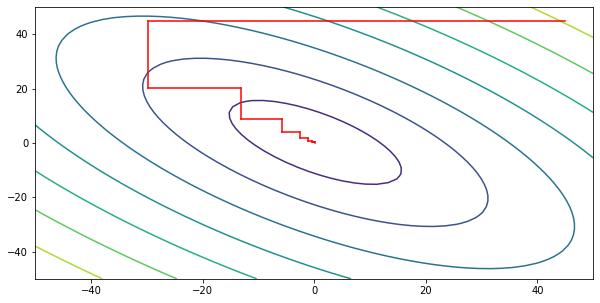

In [2]:
n, lim = 50, 50
x1, x2 = np.meshgrid(np.linspace(-lim,lim,n), np.linspace(-lim,lim,n))
X = np.concatenate([x1.reshape(n**2, 1), x2.reshape(n**2, 1)], axis=1)
A, b, c = np.eye(2)+2, np.ones((2,1)), 1
y = (X.dot(A)*X - X.dot(b)+ c).sum(axis=1).reshape(n,n)

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html#examples-using-matplotlib-pyplot-figure
fig, ax = plt.subplots(figsize = (10,5))
ax.contour(x1, x2, np.sqrt(y)) #ax.set(aspect=1)

# Assumes A, b, and c
def build_univariate_f(x_, i):
  # https://www.saltycrane.com/blog/2010/03/simple-python-decorator-examples/
  @np.vectorize  # same as `np.vecorize(f)` if `f` is defined
  # so that f works if y is a numpy.array instead of a scalar
  def f(y):
    if i:
      x = np.array([x_, y])
    else:
      x = np.array([y, x_])
    return x.dot(A).dot(x) - x.dot(b) + c
  return f

# https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
from scipy import optimize

s, x0 = 20, 45*np.ones((2,1))
for k in range(s):
  for i in range(2):
    xk = x0.copy()
    univariate_f = build_univariate_f(float(x0[1-i]), i)
    # we'll just use this numerical method rather than the analytical derivation
    xi = optimize.minimize_scalar(univariate_f, method='brent').x
    xk[i] = xi
    plt.plot([x0[0],xk[0]], [x0[1],xk[1]], 'r')  
    x0 = xk.copy()

<a name="cell-opt-fx-gauss-seidel"></a>

### Nonlinear Gauss-Seidel ([Return to TOC](#cell-solving))

---

The example above shows that in minimizing the ***nonlinear*** problem $\frac{1}{2} x^TAx - x^Tb + c$ using the cyclically iterative strategy of ***coordinate descent***, the linear update 

$$x_i^{(k+1)} = g(A_{i,\cdot},b_i,x_{-i}^{(k)}) = \frac{1}{a_{ii}}\left(b_i + \sum_{j \not = i} a_{ij}x_j^{(k)}\right)$$

of the eqivalent ***Gauss-Seidel*** solution for $x$ in $Ax=b$ is replaced with `optimize.minimize_scalar(univariate_f, method='brent').x`.

This suggests a general strategy of solving for $x$ for any ***nonlinear*** $\nabla_x f(x)=0$ equation by iteratively solving for $x_{i}^{(k+1)}$ which satisfies

$$0 = \frac{\partial}{\partial x_{i}}f(x^{(k+1)}_i,\cdots, x_{i-1}^{(k+1)}, x_{i}^{(k+1)}, x_{i+1}^{(k)},\cdots, x_{p}^{(k)})$$

In the example above, the update function $x_{i}^{(k+1)}\!=g(x_{-i}^{(k)})$ solving the partial optimization problem is an arbitrary optimization method; so, e.g., the same effect could be accomplished if $g$ was a the ***bisection*** method.  Thus, $g$ itself could be an ***iterative method***, in addition to the process of updating $x^{(k)}$ to $x^{(k+1)}$ via updating each $x_{i}^{(k)}$ to $x_{i}^{(k+1)}$  itself being an ***iterative method***. 

The relative simplicity and well-behaved nature of solving the above equation for ***nonlinear*** $f$ on the basis of cyclical iteration of univariate problems makes for a particuarly well-performing method. 

> ***Nonsquare Gauss-Seidel?***
> 
> - As presented, ***Gauss-Seidel*** is for ***square*** problems where the number of parameters $x$ and the number of outcomes $b$ have the same dimension.  This presumption is also implicit in the specification of ***Nonlinear Gauss-Seidel***. But could this work for ***nonsquare***  $A_{n\times p} x_{p \times 1} = b_{n \times 1}$ or $f(x_{p \times 1})=b_{n \times 1}$ problems? 
> 
> There are some [relatively recent results](https://arxiv.org/pdf/1706.07640.pdf) regarding convergence of the cyclically iterative strategy in the case of ***nonsquare*** (***under*** and ***overdetermined***) ***systems of linear equations*** such as $f_{A_{n\times p}}(x_{1\times p})=A_{n\times p} x_{1\times p} =b_{1\times p}$. The ***bisection*** method  $x_j^{(k+1)} = g(A_{i,\cdot},b_i,x_{-j}^{(k)})$ in this context would thus instead find
>
> $$0 = f_{A_{i,\cdot}}(x^{(k+1)}_1,\cdots, x_{j-1}^{(k+1)}, x_{j}^{(k+1)}, x_{j+1}^{(k)},\cdots, x_{p}^{(k)}) - b_i$$
>
> where $f_{A}(x)_i = f_{A_{i,\cdot}}(x) = b_i$ is assumed so $f_{A}(x)_i = b_i$ does not require the complete $A$.



<a name="cell-opt-fx-linesearch"></a>

### 4.2.3 Line Search ([Return to TOC](#cell-solving)) 

---

***Coordinate descent***, ***Gauss-Seidel***, and ***nonlinear Gauss-Seidel*** all update one direction $x_j$ at a time. While these methods are optimal in terms of maximizing the decrease in the objective function as a result of updating $x_j^{(k)}$ to $x_j^{(k+1)}$ (as seen in the quadratic example above).  In, general determining the distance to travel in the $x_j$ direction is known as a ***line search method***.  

> Notice how the "optimal" choices of ***Coordinate descent***, ***Gauss-Seidel***, and ***nonlinear Gauss-Seidel*** in the example above are not actually optimal in the sense that they require more than two steps (one along each coordinate) to find the minimum.

***Line search methods*** address the ***univariate*** ***optimization*** subproblem of updating $x_j^{(k)}$ to $x_j^{(k+1)}$ in the context of the larger ***multivariate optimization*** problem of updating $x^{(k)}$ to $x^{(k+1)}$. More generally, ***line search methods*** update $x^{(k+1)} = x_j^{(k)} + \alpha^{(k)}d^{(k)}$ by choosing the step size factor $\alpha^{(k)}$ for direction $d^{(k)}$. Given the iteration direction $d^{(k)}$, regardless of the dimension of $x$, choosing the step size is a univariate problem whose "optimal" solution $\alpha^{(k)}$ solves

$$\underset{\text{(depending on context)}}{\min_{\alpha^{(k)}} \rho(\alpha^{(k)}) \;\text{ or } \;\max_{\alpha^{(k)}} \rho(\alpha^{(k)})} \quad \text{ where } \quad \rho(\alpha^{(k)}) = f\left(x^{(k)}_j + \alpha^{(k)}d_j^{(k)}\right) = \underbrace{f\left(x^{(k)} + \alpha^{(k)}e_j^{(k)}\right)}_{\text{if updating the $x_j$ direction}}$$

> As the ***Coordinate descent***, ***Gauss-Seidel***, and ***nonlinear Gauss-Seidel*** example above shows, the "optimal" update from  $x_j^{(k)}$ to $x_j^{(k+1)}$ may not in fact be optimal in the context of the larger  $x^{(k)}$ to $x^{(k+1)}$ update.

***Line search methods*** might best be viewed as simply needing to find a reasonable (rather than optimal) step sizes for each iteration because there is going to be a computational tradeoff between finding a good $\alpha^{(k)}$ and finding a good $d^{(k)}$. Thus, finding an "optimal" $\alpha^{(k)}$ can mean dimenishing returns incurred by overemphasis on $\alpha^{(k)}$ becoming increasingly computationally wasteful when spending more effort on finding a good $d^{(k)}$ might have been a better use of computational resources.

> Solving for $\alpha^{(k)}$ in $\hat \rho'(\alpha^{(k)}) = 0$ for a polynomial approximation $\hat \rho(\alpha^{(k)}) \approx \rho(\alpha^{(k)})$ could quickly produce reasonable choices for approximatley "optimal" $\alpha^{(k)}$; or, a choice for $\alpha^{(k)}$ could be based on a few ***Ternary search*** (i.e., ***bisection*** used for optimization) or  ***Golden Section Search*** steps. 
>
> E.g., for the ***nonlinear Gauss-Seidel*** example above, using a few steps of ***bisection*** might save some computational time compared to `optimize.minimize_scalar(univariate_f, method='brent').x`. Saving computation on the 
$x_j^{(k)}$ to $x_j^{(k+1)}$ updates makes the $x^{(k)}$ to $x^{(k+1)}$ updates faster, which means overall total number of iterations $K$ could be increased. And overall, this might actually end up being more computationally efficient strategy. 
> - This is the tradeoff between the number of steps $K$ and the cost of each step.

One final worthwhile note here is that the ***line search*** problem is slightly more complicated version of ***univariate root finding***. I.e., bracketing a root with ***bisection*** only requires $\rho(\alpha_1) < 0 < \rho(\alpha_2)$; but, bracketing a local minimum requires either

$$\rho(\alpha_3)<\rho(\alpha_1) \;\textit{ and } \rho \;(\alpha_3)<\rho(\alpha_2) \quad \;\text{ or }\; \quad \overset{\text{$\rho'$ are derivaties of $\rho$}}{\rho'(\alpha_1) < 0 < \rho'(\alpha_2)}$$

which is the three-point version of the ***bisection method*** known as [***Ternary Search***](https://en.wikipedia.org/wiki/Ternary_search) (or requires derivatives).



<!-- 
The previously discussed, ***conjugate gradient methods*** endevor to determine

1. a previously unexplored iteration direction
2. an effective step size to take in that direction

> E.g., the step size factor $\alpha$ used to ensuring monotonic iteration can be chosen by ***backtracking*** (e.g., incrementally decreasing it by half) to ensure ascent or descent in the function from the result iterative update step; thus, carefully employing step size factor $\alpha$ is a ***line search*** method. 
-->



<a name="cell-opt-fx-golden"></a>

### [OMITTED] Ternary (~~Bi~~Trisection) and Golden Section Search ([Return to TOC](#cell-solving))

---

An [improved variant](https://chemicalstatistician.wordpress.com/2013/04/22/using-the-bisection-method-with-the-golden-ratio-for-numerical-optimization/) of the ***Ternary Search*** is the ***Golden Section Search*** which proposes potential interval updates based on the (inverted) *golden ratio*

$$\tau = \frac{\sqrt{5}-1}{2} = \left(\frac{\sqrt{5}+1}{2} \right)^{-1} \quad \text{ which satisfies } \quad \tau^2 = 1 - \tau$$

so that, [unlike](https://chemicalstatistician.wordpress.com/2013/04/22/using-the-bisection-method-with-the-golden-ratio-for-numerical-optimization/) a ***Ternary Search***, one of two necesasary function evaluations may actually be reused from the preceding iteration (reducing computational requirements by half):


1. given $\alpha_l$ and $\alpha_u$ between which $\rho$ is unimodal
2. set $\quad \alpha_1 = \alpha_l + (1-\tau)(\alpha_u-\alpha_l) \quad$ and $\quad \alpha_2 = \alpha_l + \tau(\alpha_u-\alpha_l)$
4. depending on the relative values of $\rho(\alpha_1)$ and $\rho(\alpha_2)$
   - replace either $\quad \alpha_l$ with $\alpha_1\quad $ or $\quad \alpha_u$ with $\alpha_2$ 
   - and correspondingly peform updates of either
      - $\alpha_1=\alpha_2$ and $\alpha_2 = \alpha_l + \tau(\alpha_u-\alpha_l)\quad$ 

        and evaluate $\rho(\alpha_2)$, but not $\rho(\alpha_1)$ which was evaluated on the preceding step

     or

      - $\alpha_2=\alpha_1$ and $\alpha_1 = \alpha_l + (1-\tau)(\alpha_u-\alpha_l)$

        and evaluate $\rho(\alpha_1)$, but not $\rho(\alpha_2)$ which was evaluated on the preceding step

5. stop or return to step 3

*This example is inspried by and uses the notation of **Algorithm 6.7 Golden Section Search** in the **Line Searches** section of Chapter **6.2 Unconstrained Descent Methods in Dense Domains** in James E. Gentle's **Computational Statistics** textbook (page 264). [Errata Warning: the second paragraph of page 264 is unnecessarily unspecific and potentially misleading in refering to the **Ternary Search** as a **Bisection Method**; in step $0$ of  **Algorithm 6.7** $\tau$ is actually the inverse of what is traditionally referred to as the **golden ratio** and so should have instead been referred to as the [silver ratio](https://en.wikipedia.org/wiki/Golden_ratio#Golden_ratio_conjugate); and, in the final paragraph on page 264 the **Golden Section Search** and the **Bisection Method** are only "linear convergent" in interval width but do not have convergence order $\beta=1$ since the limit defining this does not exist.]*


| | |
|-|-|
| ![](https://1.bp.blogspot.com/-Iof3C8PAHZQ/YL5Tg7Q1Y1I/AAAAAAAACeo/JKMn2WgMk4YtpHZ1yn2xQHjvcAq35UGZgCNcBGAsYHQ/w640-h426/animate_sin_min_geodose.gif) | ![](https://1.bp.blogspot.com/-iL2Z9ebNHbk/YL5GucHpulI/AAAAAAAACeg/uY1B9TBjvZ43WwzndkJ1AsV60nXKgtI9wCNcBGAsYHQ/w640-h426/animate_sin_max_geodose.gif) |

- https://www.geodose.com/2021/06/golden-section-search-python-application-example.html

<a name="cell-opt-fx-Goldstein-Armijo"></a>

### [OMITTED] Goldstein-Armijo Sufficient Decrease, Curvature Conditions ([Return to TOC](#cell-solving))

---

For a minimization problem, the ***sufficient decrease condition*** of the ***Goldstein-Armijo method***, for some $\tau \in (0,2^{-1})$, chooses the largest $\alpha^{(k)} = 2^{-n^{(k)}}$ such that 

$$f\left(x^{(k)} + \alpha^{(k)}d^{(k)}\right) \leq f\left(x^{(k)}\right) + \underset{c\; \geq \; -\tau \alpha^{(k)}|d^{(k)}||\nabla_x f\left(x^{(k)}\right)|}{\overbrace{\underbrace{\tau \alpha^{(k)} \left(d^{(k)}\right)^T \nabla_x f\left(x^{(k)}\right)}_{\text{is a negative scalar $c$ satisfying}}}^{\text{if $d^{(k)}$ is a descent direction this}}}$$

which, rather than guaranteeing an optimal step size, [ensures that](https://en.wikipedia.org/wiki/Backtracking_line_search#Motivation) the step size is both 

- "not too large" since $\alpha^{(k)}$ will shrink the step size until the inequality is achieved, and still
- "pretty good" based on the linear approximation $\alpha^{(k)}\left(d^{(k)}\right)^T \nabla_x f\left(x^{(k)}\right)$ of the change in the function from $x^{(k)}$ to $x^{(k)} +\alpha^{(k)}d^{(k)}$

> The ***Goldstein-Armijo method*** specifies an ***sufficient decrease condition*** (based on $\tau$). The largest ***step size factor*** $\alpha^{(k)}$ is chosen so that the decrease in $f\left(x^{(k)} + \alpha^{(k)}d^{(k)}\right)$ is as good or beter than the decrease in $l(\alpha^{(k)})$ which is proportional to the linear approximation of the function at $x^{(k)}$.=) 
>
> The general concept of the ***Goldstein-Armijo method*** is illustrated (with sligtly varied notation) in the canonical figure below (taken from [stackexchange](https://math.stackexchange.com/questions/3436826/backtracking-line-search-algorithm-why-make-a-smaller-every-time)) in which the Goldstein-Armijo method chooses the largest $\alpha$ such that $\phi(\alpha) \leq l(\alpha)$.
> ![](https://i.stack.imgur.com/5oxQI.png)

An additional criterion in which optimality is more intentionally pursued is the so-called ***curvature condition***

$$\left(d^{(k)}\right)^T \nabla_x f\left(x^{(k)} + \alpha^{(k)}d^{(k)}\right) \leq \eta \left(d^{(k)}\right)^T \nabla_x f\left(x^{(k)}\right) \quad \text{ for some } \eta \in (0,1)$$

which (for a unimodal region) simply indicates that at $x^{(k)} + \alpha^{(k)}d^{(k)}$ the function is still decreasing $\eta$-proportionally to it's linear approximation decrease at $x^{(k)}$ in the direction $d^{(k)}$, so the minimum has not been overshot.  

> For small $\eta = \epsilon > 0$ the ***curvature condition*** would fail as soon as the derivative in the direction $d^{(k)}$ at $x^{(k)} + \alpha^{(k)}d^{(k)}$, was greater than or equal to $0$, i.e., $\left(d^{(k)}\right)^Tf\left(x^{(k)} + \alpha^{(k)}d^{(k)}\right) \geq 0$. Thus, in the illustration above, the ***curvature condition*** fails for all regions of non negative slopes in $\phi(\alpha)$.

<a name="cell-sovling-gradients-steepest"></a>

## 4.2.4 Gradient (Steepest Direction) Descent ([Return to TOC](#cell-solving))

--- 

Rather than moving down the surface of a function along only a single coordinate axis, it would seem preferable to be able move along multiple coordinate axes simultaneously.  This is the idea behind ***gradient descent***.


The ***negative gradient*** of a scalar valued multivariate function $f_x$ evaluated at $x_0$

$$ -\left[\nabla_{x} (f_x)\right]\!(x_0) \; \text { which we write as } \; -\nabla_x f(x_0)$$

is the [direction of steepest descent](https://math.stackexchange.com/questions/223252/why-is-gradient-the-direction-of-steepest-ascent) of $f_x$ at $x_0$. So, e.g., for 

$$f(x) = (b - Ax)^T A^{-1} (b - Ax)$$

$$\underbrace{- \nabla_{x} f(x^{(k)}) = b - A x^{(k)}}_{\text{direction of steepest descent of $f$ at $x^{(k)}$}}$$

updating $x^{(k)}$ in the direction of steepest descent as

\begin{align*}
x^{(k+1)} = {} & x^{(k)} + \alpha \left[ - \nabla_{x} f(x^{(k)}) \right]\\
 = {} & x^{(k)} + \alpha (b - Ax^{(k)}) \; \mathbf{= O(n^2)}
\end{align*}

means that for an appropriate step size factor $\alpha$

$$f(x^{(k+1)}) < f(x^{(k)})$$

and of course if the direction $b-Ax^{(k)} = 0$ then $x^{(k)}$ is the minimum and will not change.

- Just as with ***Gauss-Seidel*** the ***iterative method*** of ***gradient descent*** is $O(sn^2)$.

> ***Gradient descent*** will be illustrated in comparison with ***conjugate gradient methods*** below; however, it's general characteristics share much in common with ***coordinate descent*** despite the fact that ***gradient descent*** is meant to be a flexibility improvement over ***coordinate descent***. An explanation for this is that while ***coordinate descent*** is resticted to move along a coordinate axis, it does so optimally; whereas, unless special step size factors $\alpha_k$ are choosen, ***gradient descent*** is not particularly optimal along the direction it is moving.  I.e., it does not find a minimum along the direction of its movement.  So both methods have symmetrical drawbacks: ***gradient descent*** chooses directions well but not step sizes, while ***coordinate descent*** chooses step sizes well but not directions.
>
>Finding both optimal directions (like ***gradient descent***) as well as optimal step sizes (like ***coordinate descent***) is what ***conjugate gradient methods*** do.

In [ ]:
# https://www.tensorflow.org/guide/autodiff
import tensorflow as tf

A = np.diag(np.ones(2)) + 1.0
Ainv = tf.constant(np.linalg.inv(A), dtype='float32')
A = tf.constant(A, dtype='float32')
b = tf.constant(np.array([[1],[1]]), dtype='float32')
x = tf.Variable([[1.0], [1.0]])

with tf.GradientTape(persistent=True) as tape:
  # f(x) = (b-Ax)^TA^{-1}(b-Ax) 
  #      = b^TA^{-1}b - 2 b^tA^{-1}Ax + (Ax)^TA^{-1}Ax
  #      = b^TA^{-1}b - 2 b^tx + (Ax)^Tx
  # gradient_x f(x) = -2b+2Ax)
  # gradient_x f(x) = -2(b-Ax)
  fx = tf.transpose(b-A@x)@Ainv@(b-A@x)

                   # gradient of fx with respect to x
gradient_x_fx = tape.gradient(fx, x)
-2*(b-A@x), gradient_x_fx
# so we don't have to actually calculate any derivatives mathematically
# we just have to write fx, and then ask for it's gradient with respect to other variables

<a name="cell-sovling-gradients-auto"></a>

### 4.2.4.0 Automatic Differentiation ([Return to TOC](#cell-solving))

--- 

When the derivative

$$ \frac{\partial f(x_1 \cdots x_{i+1} \cdots x_m)}{dx_i} = \underset{h \rightarrow 0}{\lim} \frac{f(x_1 \cdots x_{i+1}+h \cdots x_m)-f(x)}{h}$$

exists, it can be numerically approximated with [***finite differences numerical differentiation***](https://en.wikipedia.org/wiki/Numerical_differentiation) with sufficient convergence of

$$ \frac{f(x_1 \cdots x_i^{(k)} \cdots x_m)-f(x_1 \cdots x_i \cdots x_m)}{x^{(k)}-x_i} \longrightarrow c \approx \frac{\partial f(x)}{dx_i} $$

$$ \text{as $x^{(k)}_i \longrightarrow  x_i$ for increasing $k=1,2,...,K$}.$$

However, such a method of computing derivatives will be computationally prohibitive. Fortunately, for many simple functions, such as $f(x) = Ax-b$, analytical derivatives are already known. Further, thanks to the [***chain rule***](https://en.wikipedia.org/wiki/Chain_rule) [for derivatives](https://en.wikipedia.org/wiki/Chain_rule_(probability)), derivatives of complicated functions which are made up of simpler functions for which analytical derivatives are already known can themselves also be derived analytically in an algorithmic manner. This is what the current generation of so-called [***automatic differentiation***](https://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/readings/L06%20Automatic%20Differentiation.pdf) tools do. 

This has led to many breakthrough methodologies and technologies (e.g., [Deep Neural Networks](#cell-f-dnn)) which are only possible through ***automatic differentiation***.

> When derivatives, partial derivatives, or gradients are needed, they can often be calculated using ***automatic differentiation*** without any need for new manual differentiation. Indeed, much modern methology no longer relies on analytically calculating derivatives by hand, and rather just relies on ***automatic differentiation*** frameworks.

***Automatic differentiation*** has been incorporated into extremely powerful computational frameworks supported by the largest technology companies, e.g., [TensorFlow](https://www.tensorflow.org/) from Google,
[PyTorch](https://pytorch.org/) from Facebook, and [MXNET](https://mxnet.apache.org/versions/1.9.0/) from Apache.  Of specific note are Google's efforts with [TensorFlow Probability](https://www.tensorflow.org/probability), and [PyMC](https://docs.pymc.io/en/v3/) which after some [initial interest](https://pymc-devs.medium.com/theano-tensorflow-and-the-future-of-pymc-6c9987bb19d5) in TensorFlow decided to stay with their original AutoDiff framework [Theano](https://en.wikipedia.org/wiki/Theano_(software)) with support from [Jax](https://pymc-devs.medium.com/the-future-of-pymc3-or-theano-is-dead-long-live-theano-d8005f8a0e9b). Some viable alternatives to PyMC are [Stan](https://mc-stan.org/) (based on custom proprietary AutoDiff) and [Edward](http://edwardlib.org/) (based on TensorFlow).

<a name="cell-sovling-conjugate"></a>

### 4.2.4.1 Conjugate Gradient Methods ([Return to TOC](#cell-solving))

--- 

Even though $-\nabla_x f(x^{(k)})$ is the [direction of steepest descent](https://math.stackexchange.com/questions/223252/why-is-gradient-the-direction-of-steepest-ascent) of the scalar valued multivariate function $f$ at domain location $x^{(k)}$, steps following these directions 

$$d_k = -\nabla_x f(x^{(k)}) \quad \text{ and } \quad x^{(k+1)} = x^{(k)} + \alpha d_k$$

(often) may not efficiently approach $x^* = \text{argmin} f(x)$ (as the examples below demonstrate). 

Instead, $x^* = \text{argmin} f(x)$ can be approached more efficiently 
by using a variant $\tilde{d_k}$ of $d_k$ which satisfies $\tilde{A^*}$-***conjugacy*** (i.e., ***Q-conjugacy*** with respect to $\tilde{A^*}$)

$$\tilde{d_j}^T \!\!\tilde{A^*}\tilde{d_k}=0 \text{ for } j=0,...,k-1 \quad \text{ where } \quad \tilde{A^*} \text{ characterizes $f$'s orientation}$$

and then taking steps along these ***Q-conjugate*** directions

$$x^{(k+1)} = x^{(k)} + {\alpha_k} \tilde{d_k} \quad \text{ where } \quad {\alpha_k} \text{ is chosen to maximize }  \underset{\text{for the adjustment } {\alpha_k}\tilde{d^{(k)}}}{\overset{\text{change in the direction }\tilde{d_k}}{f(x^{(k)})-f(x^{(k+1)})}}$$



> There are two convenient ways to use a ***conjugate gradient method*** for
>
> $$f(x) = (b - Ax)^T A^{-1} (b - Ax) \quad \text{ with } \quad -\nabla_x f(x^{(k)}) = b - Ax^{(k)}$$
> 
> 
> A. The most common approach is based on [$A$-***conjugacy***](https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_resulting_algorithm):
> 0. Let $\tilde{A^*}=A$, and for any initial $x^{(0)}$
> 1. Set $\tilde{d_0} = d_0 = -\nabla_x f(x^{(0)})$
> 2. Then enforce $A$-***conjugacy*** 
>   - $\tilde{d_k}^T\!\!A\,\tilde{d_j}=0$ for all $k>0$ and $j=0,...,k-1$ 
>
>     by choosing $\tilde{d_k}$ through a ***Gram-Schmidt-like*** procedure which provides an "$A$-***conjugate*** orthogonalization"
> 3. and use the optimal step size factor ${\alpha_k}$ as specified by [the algorithm](https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_resulting_algorithm)

>  
> B. An alternative approach is based on $A^2$-*conjugacy*:
> 0. Let $\tilde{A^*}=A^2 = AA$, and for any initial $x^{(0)}$
> 1. Set $\tilde{d_0} = Ad_0 = Ar^{(0)} = A(\overbrace{\underset{\text{the "residual"}}{b-Ax^{(0)}}}^{r^{(0)}})$
> 2. Update the step size factor ${\alpha_k} = \frac{||{\tilde d^{(k-1)}}||_2^2}{||A{\tilde d^{(k-1)}}||_2^2}$ and 
>   - $x^{(k)} = x^{(k-1)} + \frac{||{\tilde d^{(k-1)}}||_2^2}{||A{\tilde d^{(k-1)}}||_2^2} {\tilde d^{(k-1)}}$
>   - $b-Ax^{(k)} = b-Ax^{(k-1)} - \frac{||{\tilde d^{(k-1)}}||_2^2}{||A{\tilde d^{(k-1)}}||_2^2} A{\tilde d^{(k-1)}}$
>   - $r^{(k)} = r^{(k-1)} - \frac{||{\tilde d^{(k-1)}}||_2^2}{||A{\tilde d^{(k-1)}}||_2^2} A{\tilde d^{(k-1)}}$
>
> so the [projection](https://en.wikipedia.org/wiki/Vector_projection) of $r^{(k-1)}$ onto $A\tilde d^{(k-1)}$ is removed from $r^{(k-1)}$ to produce $r^{(k)}$ which now has no contribution in the $A\tilde d^{(k-1)}$ direction. 
>
> 3. set $\tilde{d_{k}} = A(\overbrace{\underset{\text{the "residual"}}{b-Ax^{(k)}}}^{r^{(k)}}) + \overbrace{\frac{||Ar^{(k)}||_2^2}{||{\tilde d^{(k-1)}}|| _2^2}}^{\omega}{\tilde d^{(k-1)}}$ which (as demonstrated below) will ensure $A^2$-*conjugacy* 
>   - $\tilde{d_k}^T\!\!A^2\,\tilde{d_j}=0$ for all $k>0$ and $j=0,...,k-1$ 

The congugate gradients we use above satisfy $A^2$-***conjugacy*** $\tilde{d_0}^T\!\!A^2\tilde{d_1} = 0$ 

because of the $\omega$ adjustment to the $A$-transform of the "residual", i.e., 

\begin{align*}
\tilde{d^{(0)}} = {} & Ar_{0} & r_{1} = {} & r_{0} - \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} A\tilde{d^{(0)}}\\
\tilde{d^{(1)}} = {} & Ar_{1} + \overbrace{\frac{||Ar_{1}||_2^2}{||\tilde{d^{(0)}}|| _2^2}}^{\omega}\tilde{d^{(0)}}  & Ar_{1} = {} & \tilde{d^{(0)}} - \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} A^2\tilde{d^{(0)}}\\
\tilde{d^{(1)}} = {} & \tilde{d^{(0)}} - \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} A^2\tilde{d^{(0)}} + \frac{||Ar_{1}||_2^2}{||\tilde{d^{(0)}}|| _2^2}\tilde{d^{(0)}}  & ||Ar_{1}||_2^2 = {} & \left(\tilde{d^{(0)}} - \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} A^2\tilde{d^{(0)}}\right)^T\left(\tilde{d^{(0)}} - \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} A^2\tilde{d^{(0)}}\right)\\
\tilde{d^{(1)}} = {} & \tilde{d^{(0)}} - \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} A^2\tilde{d^{(0)}} + \frac{- ||\tilde{d^{(0)}}||_2^2 + \left( \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} \right)^2 ||A^2\tilde{d^{(0)}}||_2^2 }{||\tilde{d^{(0)}}|| _2^2}\tilde{d^{(0)}} & = {} & ||\tilde{d^{(0)}}||_2^2 - 2 \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} ||A\tilde{d^{(0)}}||_2^2 + \left( \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} \right)^2 ||A^2\tilde{d^{(0)}}||_2^2 \\
\tilde{d^{(1)}} = {} & \tilde{d^{(0)}} - \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} A^2\tilde{d^{(0)}} + \left(- 1 +  \frac{||\tilde{d^{(0)}}||_2^2}{\left(||A\tilde{d^{(0)}}||_2^2\right)^2}  ||A^2\tilde{d^{(0)}}||_2^2 \right) \tilde{d^{(0)}} & = {} &  - ||\tilde{d^{(0)}}||_2^2 + \left( \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} \right)^2 ||A^2\tilde{d^{(0)}}||_2^2 \\
\tilde{d^{(1)}} = {} &  - \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} A^2\tilde{d^{(0)}} +  \frac{||\tilde{d^{(0)}}||_2^2}{\left(||A\tilde{d^{(0)}}||_2^2\right)^2}  ||A^2\tilde{d^{(0)}}||_2^2 \tilde{d^{(0)}} \\
\tilde{d^{(0)}}^T\!\!A^2\tilde{d^{(1)}} = {} &  - \frac{||\tilde{d^{(0)}}||_2^2}{||A\tilde{d^{(0)}}||_2^2} ||A^2\tilde{d^{(0)}}||^2_2 +  \frac{||\tilde{d^{(0)}}||_2^2}{\left(||A\tilde{d^{(0)}}||_2^2\right)^2}  ||A^2\tilde{d^{(0)}}||_2^2 ||A\tilde{d^{(0)}}||_2^2 \\
= {} & 0
\end{align*}


*This example is inspired by Algorithm 5.3 **The Conjugate Gradient Method for Solving the Symmetric Positive Definite System $Ax=b$** in the **Conjugate Gradient Methods for Symmetric Poitive Definite Systems** section of Chapter 5.4 **Iterative Methods** on pages 223-225 of James E. Gentle's **Computational Statistics** textbook; however, contrary to the presentation there and demonstration here which are based on $A^2$-conjugacy, the conjugate gradient method is more commonly presented using an [alternative formulation](https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_resulting_algorithm) based instead on $A$-conjugacy. [Errata Warning: the discussion on pages 223-225 implies Algorithm 5.3 is based on $A$-conjugacy when in fact it is based on $A^2$-conjugacy; and the superscripts in the equation at the top of page 224 are indexed incorrectly and should start from $\alpha^{(0)}p^{(0)}$ rather than $\alpha^{(1)}p^{(1)}$]*.

<Figure size 432x288 with 0 Axes>

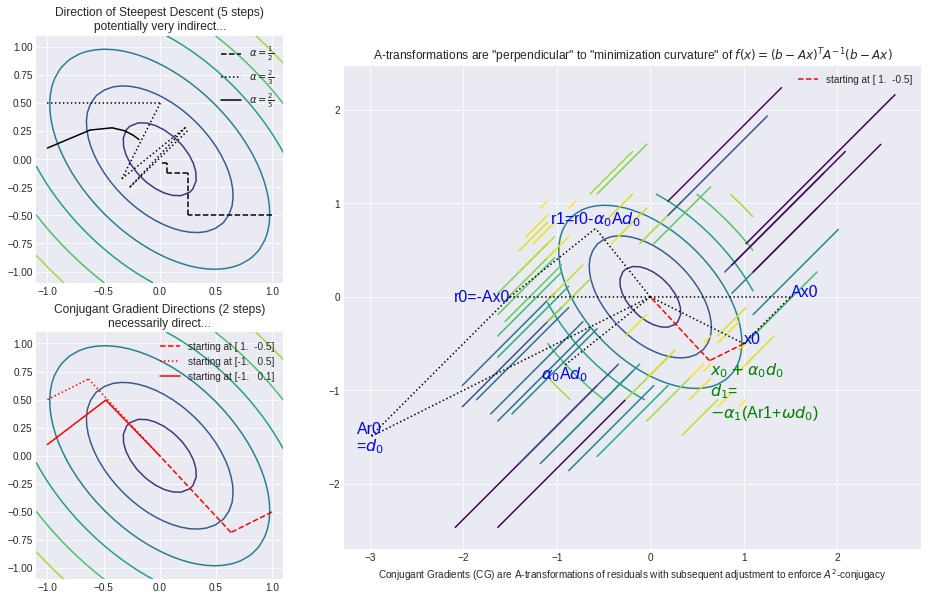

In [3]:
def plot_2D_gradient_descent(current, gradient, stepsize, 
                             ax, label=None, style='k'):

  """
    plots on `ax` with `label` and `style`
    a line from the 2D point `current` 
    in the negative 2D direction of `gradient` 
    with length of `stepsize` times `gradient`
  """

  next = current - stepsize*gradient

  ax.plot([current[0],next[0]], [current[1],next[1]], style, label=label)
  return next
                   

def plot_2D_conjugant_gradient(
  A, current_proposal, residual, Ar, Ar_L2sq, conjugant_gradient, 
  ax, label=None, style='k', verbose=None):

  """
    plots on `ax` with `label` and `style`
    a line from the 2D point `current_proposal` 
    in the direction of the conjugate gradient 
    with length of `correct_stepsize` times the conjugate gradient
    
    A                  : system of linear equations Ax=b being solved for x
    current_proposal   : a current choice for x in Ax=b
    residual           : b - Ax where x is current_proposal
    Ar                 : Ar where r is residual
    Ar_L2sq            : squared L2 norm of Ar 
    conjugant_gradient : direction which was moved resulting in current_proposal
    verbose            : provides verbose explanatory illustrative plotting 

    returns: iterated_proposal, new_residual, new_Ar, new_Ar_L2sq, new_conjugant_gradient
  """

  # b = 0 # ignored for simplicity
  # A-transformations are "perpendicular" to "minimization curvature" of b-Ax
  # residual = 0 - A.dot(current)             # given as function argument
  # Ar = A.dot(residual)                      # given as function argument
  # Ar_L2sq = Ar.dot(Ar) # L2-norm squared    # given as function argument

  # A-transformations are "perpendicular" to "minimization curvature" of b-Ax
  # direction of change in the residual 
  Aconjugant_gradient = A.dot(conjugant_gradient) 
  Aconjugant_gradient_L2sq = Aconjugant_gradient.dot(Aconjugant_gradient)
  # update requires a specific stepsize in the conjugant_gradient direction
  correct_stepsize_V1 = Ar_L2sq/Aconjugant_gradient_L2sq

  # x_new = x_old + delta
  iterated_proposal = current_proposal + correct_stepsize_V1*conjugant_gradient

  ax.plot([current_proposal[0],iterated_proposal[0]], 
          [current_proposal[1],iterated_proposal[1]], style, label=label)

  old_residual = residual[:] 
  # new_residual = b - A.dot(iterated_proposal) 
  # new_residual = b - A.dot(current_proposal + correct_stepsize*conjugant_gradient) 
  # new_residual = b - A.dot(current_proposal) - A.dot(correct_stepsize*conjugant_gradient) 
  # new_residual = old_residual - correct_stepsize*Aconjugant_gradient
  # new_residual = b - A(x_old+epsilon*delta) = (b - A(x_old)) - epsilon*A(delta)
  new_residual = residual - correct_stepsize_V1*Aconjugant_gradient
  new_Ar = A.dot(new_residual)
  new_Ar_L2sq = new_Ar.dot(new_Ar)
  # update requires a specific stepsize in the conjugant_gradient direction
  correct_stepsize_V2 = new_Ar_L2sq/Ar_L2sq

  # adjust Ar so result is A-conjugate with previous conjugant_gradients  
  old_conjugant_gradient = conjugant_gradient
  conjugant_gradient = new_Ar + correct_stepsize_V2*conjugant_gradient

  # will be returned from function below after verbose plotting just next
  output = \
  iterated_proposal, new_residual, new_Ar, new_Ar_L2sq, conjugant_gradient

  if not verbose is None:

    ax.plot([0, current_proposal[0]], [0, current_proposal[1]], 'k:')
    ax.text(current_proposal[0], current_proposal[1], 
            'x'+verbose, fontsize=16, c='blue')

    ax.plot([0, A.dot(current_proposal)[0]], [0, A.dot(current_proposal)[1]], 'k:')
    ax.text(A.dot(current_proposal)[0], A.dot(current_proposal)[1], 
            'Ax'+verbose, fontsize=16, c='blue')

    ax.plot([current_proposal[0], A.dot(current_proposal)[0]], 
            [current_proposal[1], A.dot(current_proposal)[1]], 'k:')

    ax.plot([0,old_residual[0]], [0,old_residual[1]], 'k:')
    ax.text(old_residual[0], old_residual[1], 'r'+verbose+'=-Ax'+verbose, 
            fontsize=16, c='blue',
            horizontalalignment='right', verticalalignment='center')
    
    ax.plot([old_residual[0], A.dot(old_residual)[0]], 
            [old_residual[1], A.dot(old_residual)[1]], 'k:')
    ax.text(A.dot(old_residual)[0], A.dot(old_residual)[1], 
            'Ar'+verbose, fontsize=16, c='blue', verticalalignment='bottom', 
            horizontalalignment='center')
    ax.plot([0,old_conjugant_gradient[0]], [0,old_conjugant_gradient[1]], 'k:')
    ax.text(old_conjugant_gradient[0], old_conjugant_gradient[1], 
            '=$d_0$', fontsize=16, c='blue', verticalalignment='top', 
             horizontalalignment='center')

    ax.plot([0, correct_stepsize_V1*Aconjugant_gradient[0]], 
            [0, correct_stepsize_V1*Aconjugant_gradient[1]], 'k:')
    ax.text(correct_stepsize_V1*Aconjugant_gradient[0], 
            correct_stepsize_V1*Aconjugant_gradient[1], 
            '$\\alpha_0$A$d_0$', fontsize=16, c='blue', 
            verticalalignment='top', horizontalalignment='center')
    ax.plot([old_residual[0], 
             old_residual[0] - correct_stepsize_V1*Aconjugant_gradient[0]], 
            [old_residual[1], 
             old_residual[1] - correct_stepsize_V1*Aconjugant_gradient[1]], 'k:')
    ax.plot([0, old_residual[0] - correct_stepsize_V1*Aconjugant_gradient[0]], 
            [0, old_residual[1] - correct_stepsize_V1*Aconjugant_gradient[1]], 'k:')
    ax.text(old_residual[0] - correct_stepsize_V1*Aconjugant_gradient[0], 
            old_residual[1] - correct_stepsize_V1*Aconjugant_gradient[1], 
            'r'+str(int(verbose)+1)+'=r'+verbose+'-$\\alpha_0$A$d_0$', 
            fontsize=16, c='blue', 
            horizontalalignment='center', verticalalignment='bottom')

    Aconjugant_gradient = A.dot(conjugant_gradient)
    ACG_L2sq = Aconjugant_gradient.dot(Aconjugant_gradient)
    tmp = -new_Ar_L2sq/ACG_L2sq*(conjugant_gradient)
    ax.text(tmp[0], tmp[1], 
            '$x_0+\\alpha_0 d_0$\n$d_1$=\n$-\\alpha_1$(Ar'+str(int(verbose)+1)+'+$\\omega d_0$)', 
            fontsize=16, c='green', 
            horizontalalignment='left', verticalalignment='top')
    
  return output


# https://matplotlib.org/stable/gallery/images_contours_and_fields/contour_demo.html
n = 30
x1,x2 = np.meshgrid(np.linspace(-1.1,1.1,n),np.linspace(-1.1,1.1,n))
X = np.concatenate([x1.reshape(n**2, 1), x2.reshape(n**2, 1)], axis=1)
# for the min_x ||(Ax-b)^TA(Ax-b)||_2 problem (with b=0) and
A = np.diag([1,1])+1.
#y = (X.dot(A).dot(np.linalg.inv(A))*X.dot(A)).sum(axis=1).reshape(n,n)
y = (X.dot(A)*X).sum(axis=1).reshape(n,n) # same as above

plt.style.use('seaborn-darkgrid') # whitegrid
plt.set_cmap("viridis")
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(231)
# https://stackoverflow.com/questions/7965743/how-can-i-set-the-aspect-ratio-in-matplotlib
ax.set_aspect('equal')
ax.contour(x1, x2, np.sqrt(y))


x0s = np.array([1, -0.5]), np.array([-1, 0.5]), np.array([-1, .1])
epsilons = 0.5, 0.67, 0.2
labels = "$\\alpha=\\frac{1}{2}$", "$\\alpha=\\frac{2}{3}$", "$\\alpha=\\frac{2}{5}$"
styles = 'k--', 'k:', 'k'
for x0, epsilon, label, style in zip(x0s, epsilons, labels, styles):
  for label in [label]+4*[None]:
    x0 = plot_2D_gradient_descent(current=x0, gradient=A.dot(x0), stepsize=epsilon, 
                                  ax=ax, label=label, style=style)

ax.legend()
ax.set_title('Direction of Steepest Descent (5 steps)\npotentially very indirect...')


ax = fig.add_subplot(234)
ax.contour(x1, x2, np.sqrt(y))
ax.set_aspect('equal')


# initializing conjugant_gradient=0 and CG_L2sq=1 to disappear first time 
initial_proposal = np.array([1, -0.5])

x0s = np.array([1, -0.5]), np.array([-1, 0.5]), np.array([-1.0, 0.1])
styles = 'r--', 'r:', 'r'
for initial_proposal, style in zip(x0s, styles):
  r = -A.dot(initial_proposal)
  Ar = A.dot(r)
  Ar_L2sq = Ar.dot(Ar)
  updated_proposal, r, Ar, Ar_L2sq, conjugant_gradient= \
  plot_2D_conjugant_gradient(A, initial_proposal, r, Ar, Ar_L2sq, 
                             conjugant_gradient=Ar, ax=ax, style=style,
                             label="starting at "+str(initial_proposal))
  plot_2D_conjugant_gradient(A, updated_proposal, r, Ar, Ar_L2sq, 
                             conjugant_gradient, ax=ax, style=style)

ax.legend()
ax.set_title('Conjugant Gradient Directions (2 steps)\nnecessarily direct...')


ax = fig.add_subplot(2,3,(2,6))
cmap = matplotlib.cm.get_cmap('viridis')
ax.set_aspect('equal')
for a,b in zip(X,X.dot(A)): 
  if stats.bernoulli(.1*np.abs(a[0]-a[1])).rvs(1)[0]:
    plt.plot([a[0],b[0]],[a[1],b[1]], color=cmap(1-(a-b).dot(a-b)/3))
ax.contour(x1, x2, np.sqrt(y))

initial_proposal = np.array([1, -0.5])
style = 'r--'
r = -A.dot(initial_proposal)
Ar = A.dot(r)
Ar_L2sq = Ar.dot(Ar)
updated_proposal, r, Ar, Ar_L2sq, conjugant_gradient = \
plot_2D_conjugant_gradient(A, initial_proposal, r, Ar, Ar_L2sq, 
                           conjugant_gradient=Ar, ax=ax, style=style,
                           label="starting at "+str(initial_proposal), 
                           verbose="0")#"0"
plot_2D_conjugant_gradient(A, updated_proposal, r, Ar, Ar_L2sq,  
                           conjugant_gradient, ax=ax, style=style,
                           verbose=None)

ax.legend()
ax.set_title('A-transformations are "perpendicular" to "minimization curvature" of $f(x) = (b-Ax)^TA^{-1}(b-Ax)$')
_ = ax.set_xlabel('Conjugant Gradients (CG) are A-transformations of residuals with subsequent adjustment to enforce $A^2$-conjugacy')

<a name="cell-sovling-gdall"></a>

### 4.2.4.2 When is Gradient Descent all that's needed? ([Return to TOC](#cell-solving))

--- 

***Congugate gradient methods*** are designed to use ***gradients***, but to adjust them carefully in conjunction with a sophisticated ***line search method*** so the iterative process overall is efficiently directing towards the optimum.  The reason this is necessary is because, as is demonstrated above, if the ***step size factor*** in ***gradient descent*** is not chosen well, then the ***line search*** aspect of ***gradient descent*** is poor, and then the iterative ***gradient descent*** process does not progress towards the optimum efficiently.

But is it always the case that ***gradient descent*** will not not progress towards the optimum efficiently?

|![](https://cdn-images-1.medium.com/max/1600/1*vXpodxSx-nslMSpOELhovg.png)|
|:-:|
|[Blog discussing normalization, but applies to loss functions as well](https://machinelearningnotepad.wordpress.com/2018/04/15/gradient-descent/)|

***Gradient descent*** would move in the optimal direction efficiently if the objective function being traversed was ***isotropic*** (i.e., spherically symmetric) rather than ***anisotropic*** (i.e., oval or elliptical with a diagonal major axis). This is because in the ***anisotropic*** case the negative gradients do not point towards the minimum of the function, whereas in the ***isotropic*** case they do. ***Congugate gradient methods*** are helpful for the ***anisotropic*** case, but are completely unnecessary for the ***isotropic*** case.  Now, each step in ***gradient descent*** does move in the right direction; but, the ***step size factor*** could still be optimized through a ***line search method*** so that not too many ***gradient descent*** iterative steps are required to get close to the optimum. 

> You can check this [here](https://elsenaju.eu/Calculator/gradient-2d-plot.htm) for $xAx^T$, e.g., $A=\left[\begin{array}{cc} a&0\\0&b \end{array}\right]$ with the formula `(x*a+y*0)*x + (x*0+y*b)*y` with `a=1` and `b=1`.

